In [1]:
# with inverse propensity score
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from collections import Counter
import scipy.sparse as sparse
from sklearn.ensemble import RandomForestClassifier
# os is a handy module to explore operating system directory
import os
#filepath = 'C:/Users/I008328/Desktop/AIA/Next Recommended Actions/'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#pd.set_option('display.max_columns', None)

In [ ]:
#: 1to2 <2 ; 2to5 <5
#cut_labels = ['1-2y','2-5y','>=5y']
#cut_bins = [0,1.9,4.9,df['TRUE_AGT_JOIN_YR'].max()]
#df['Type'] = pd.cut(df['TRUE_AGT_JOIN_YR'],bins=cut_bins,labels=cut_labels)

### START HERE

In [10]:
#df = pd.read_csv('NRA_train_v2.csv')
df = pd.read_csv('NRA_train_v3.csv')
df_inc = pd.read_csv('NRA_INCOME_FEB_2020.csv')
df.shape , df_inc.shape

((376463, 68), (2358653, 3))

In [11]:
df_inc.drop_duplicates(subset='INS_ID',keep='first',inplace=True, ignore_index=True)
df_inc.shape

(2322767, 3)

In [12]:
df = df.drop(df[(df.FLG_SUM == 1) & (df.FLG_POL_ANNIVERSARY_1M == 'Y') &(df.TARGET_REPUR_IND == 0)].index)
df.shape

(259511, 68)

In [13]:
df = df.drop(df[(df.FLG_SUM == 1) & (df.FLG_BIRTHDAY == 'Y') &(df.TARGET_REPUR_IND == 0)].index)
df.shape

(137938, 68)

In [14]:
df2 = df.copy()

In [15]:
df2.TARGET_REPUR_IND.value_counts()

0.0    129955
1.0      7983
Name: TARGET_REPUR_IND, dtype: int64

In [16]:
df2 =df2[df2['INS_LIFE_STAGE'].notna()]
df2.shape

(136708, 68)

In [17]:
df2.TARGET_REPUR_IND.value_counts()

0.0    128900
1.0      7808
Name: TARGET_REPUR_IND, dtype: int64

In [18]:
df_train = df2.merge(df_inc, on='INS_ID', how='left')
#df_base2 = df_base1.merge(df_fam_acute, on='SCV_ID', how='left')
df_train.shape

(136708, 70)

In [ ]:
#pd.options.display.float_format = '{:,.7f}'.format
#df_train.var().sort_values(ascending=False)

imputer = SimpleImputer(missing_values =np.NaN, strategy = 'most_frequent')
df_train['INS_LIFE_STAGE'] = imputer.fit_transform(df_train['INS_LIFE_STAGE'].values.reshape(-1,1))[:,0]
df_train['INS_OCCUPATON'] = imputer.fit_transform(df_train['INS_OCCUPATON'].values.reshape(-1,1))[:,0]

In [ ]:
#https://stackoverflow.com/questions/29298973/removing-features-with-low-variance-using-scikit-learn
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.1):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select
#fs_variance(df_train, 0.1)

In [19]:

df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].apply(pd.Series.value_counts)

FLG_21  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
N  130000       133371          100677             134472   
Y    6708         3337           36031               2236   

   FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
N                  101724         94675           106157   
Y                   34984         42033            30551   

   FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  FLG_CALL_TRIGGER  
N                 135357             134790           136424            130877  
Y                   1351               1918              284              5831

In [20]:
df_inverse = df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].apply(pd.Series.value_counts)
df_inverse.loc['N']/df_inverse.loc['Y']

FLG_21                     19.379845
FLG_MARRIED                39.967336
FLG_LIFE_STAGE              2.794177
FLG_INCOME_CHANGE          60.139535
FLG_POL_ANNIVERSARY_1M      2.907729
FLG_BIRTHDAY                2.252397
FLG_CLM_TRIGGER             3.474747
FLG_NON_ACUTE_CLM_FAM     100.190229
FLG_ACUTE_CLM_FAM          70.276330
FLG_ACC_CLM_FAM           480.366197
FLG_CALL_TRIGGER           22.445035
dtype: float64

In [21]:
list_inv = list(df_inverse.loc['N']/df_inverse.loc['Y'])
list_inv

[19.37984496124031,
 39.96733593047647,
 2.7941772362687685,
 60.13953488372093,
 2.9077292476560714,
 2.252396926224633,
 3.474747144119669,
 100.1902294596595,
 70.27632950990615,
 480.36619718309856,
 22.44503515691991]

In [22]:
lst1 = [0.0277,0.1097,0.0379,0.0923,0.0136,0.0203,0.0257,0.0357,0.0387,0.0309,0.0647]
inv_flags = []
for k,v in zip(lst1,list_inv):
    inv_flags.append(k*v)
    print(k*v)
print(inv_flags)

0.5368217054263565
4.384416751573269
0.10589931725458633
5.550879069767441
0.03954511776812257
0.045723657602360045
0.0893010016038755
3.5767911917098445
2.7196939520333676
14.843315492957746
1.452193774652718
[0.5368217054263565, 4.384416751573269, 0.10589931725458633, 5.550879069767441, 0.03954511776812257, 0.045723657602360045, 0.0893010016038755, 3.5767911917098445, 2.7196939520333676, 14.843315492957746, 1.452193774652718]


In [23]:
# Map Y,N to 1,0
targets = {'Y':1, 'N':0}
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']] = \
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].stack().map(targets).unstack()

In [24]:
df_flags = df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].copy()
df_flags.head()

FLG_21  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
0       0            0               0                  0   
1       0            0               0                  0   
2       0            0               0                  1   
3       0            0               0                  0   
4       0            0               0                  0   

   FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
0                       0             1                0   
1                       0             0                1   
2                       0             0                0   
3                       0             1                0   
4                       1             1                0   

   FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  FLG_CALL_TRIGGER  
0                      0                  0                0                 0  
1                      0                  0                0                 0  
2                      0                  0                0                 0  
3                      0                  0                0                 0  
4                      0                  0                0                 0

In [25]:
# Map Flags to their respective repurchase rate
lst = ['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']


In [26]:
# Populate flags columns with respective repurchase rate
for k,v in zip(lst,inv_flags):
    df_train[k] = df_train[k].apply(lambda x: v if x == 1 else 0)
    

In [27]:
#sanity check
print(df_train['FLG_MARRIED'].loc[df_train['FLG_MARRIED']>0].head(5))
print(df_train['FLG_POL_ANNIVERSARY_1M'].loc[df_train['FLG_POL_ANNIVERSARY_1M']>0].head(5))
print(df_train['FLG_CLM_TRIGGER'].loc[df_train['FLG_CLM_TRIGGER']>0].head(5))
print(df_train['FLG_CALL_TRIGGER'].loc[df_train['FLG_CALL_TRIGGER']>0].head(5))
print(df_train['FLG_21'].loc[df_train['FLG_21']>0].head(5))
print(df_train['FLG_BIRTHDAY'].loc[df_train['FLG_BIRTHDAY']>0].head(5))
print(df_train['FLG_INCOME_CHANGE'].loc[df_train['FLG_INCOME_CHANGE']>0].head(5))

11     4.384417
27     4.384417
43     4.384417
50     4.384417
100    4.384417
Name: FLG_MARRIED, dtype: float64
4     0.039545
6     0.039545
8     0.039545
10    0.039545
14    0.039545
Name: FLG_POL_ANNIVERSARY_1M, dtype: float64
1     0.089301
5     0.089301
13    0.089301
17    0.089301
19    0.089301
Name: FLG_CLM_TRIGGER, dtype: float64
36     1.452194
43     1.452194
116    1.452194
148    1.452194
161    1.452194
Name: FLG_CALL_TRIGGER, dtype: float64
7      0.536822
119    0.536822
133    0.536822
157    0.536822
172    0.536822
Name: FLG_21, dtype: float64
0     0.045724
3     0.045724
4     0.045724
14    0.045724
15    0.045724
Name: FLG_BIRTHDAY, dtype: float64
2      5.550879
82     5.550879
138    5.550879
142    5.550879
175    5.550879
Name: FLG_INCOME_CHANGE, dtype: float64


In [144]:
#for i in lst:
#    df_train[i] = np.where(df_train[i]>0,df_train[i]-df_train[i].mean(),0)

In [28]:
# divide by flag sum
for i in lst:
    df_train[i] = df_train.apply(lambda x: x[i]/x['FLG_SUM'] if x[i] > 0 else 0,axis=1)
    #df_train[i] = df_train.apply(lambda x: x[i] * x['Repurchase_ratio'] if x[i] > 0 else 0,axis=1)
    

In [21]:
#sanity check
print(df_train['FLG_MARRIED'].loc[df_train['FLG_MARRIED']>0].head(5))
print(df_train['FLG_POL_ANNIVERSARY_1M'].loc[df_train['FLG_POL_ANNIVERSARY_1M']>0].head(5))
print(df_train['FLG_CLM_TRIGGER'].loc[df_train['FLG_CLM_TRIGGER']>0].head(5))
print(df_train['FLG_CALL_TRIGGER'].loc[df_train['FLG_CALL_TRIGGER']>0].head(5))
print(df_train['FLG_21'].loc[df_train['FLG_21']>0].head(5))
print(df_train['FLG_BIRTHDAY'].loc[df_train['FLG_BIRTHDAY']>0].head(5))
print(df_train['FLG_INCOME_CHANGE'].loc[df_train['FLG_INCOME_CHANGE']>0].head(5))

30     2.192208
70     4.384417
98     1.461472
122    1.461472
249    2.192208
Name: FLG_MARRIED, dtype: float64
12    0.019773
17    0.019773
23    0.019773
28    0.019773
33    0.019773
Name: FLG_POL_ANNIVERSARY_1M, dtype: float64
3     0.044651
15    0.029767
32    0.029767
43    0.044651
49    0.044651
Name: FLG_CLM_TRIGGER, dtype: float64
89     0.726097
98     0.484065
302    0.484065
379    1.452194
408    0.484065
Name: FLG_CALL_TRIGGER, dtype: float64
22     0.536822
305    0.536822
338    0.536822
398    0.536822
434    0.536822
Name: FLG_21, dtype: float64
1     0.015241
8     0.022862
12    0.022862
33    0.022862
34    0.022862
Name: FLG_BIRTHDAY, dtype: float64
4      5.550879
202    2.775440
353    5.550879
357    1.387720
444    5.550879
Name: FLG_INCOME_CHANGE, dtype: float64


In [29]:
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER','FLG_SUM','TARGET_REPUR_IND']].sum()

FLG_21                      3304.688478
FLG_MARRIED                 8361.051428
FLG_LIFE_STAGE              2896.815057
FLG_INCOME_CHANGE           8651.785147
FLG_POL_ANNIVERSARY_1M       682.501279
FLG_BIRTHDAY                 965.226847
FLG_CLM_TRIGGER             1131.888069
FLG_NON_ACUTE_CLM_FAM       3156.279774
FLG_ACUTE_CLM_FAM           3615.697125
FLG_ACC_CLM_FAM             2922.154043
FLG_CALL_TRIGGER            6342.165872
FLG_SUM                   260658.000000
TARGET_REPUR_IND            7808.000000
dtype: float64

In [ ]:
# ** flg_sum+1  if repurchase == 0 to make the value smaller as there is no repurchase
for i in lst:
    df_train[i] = df_train.apply(lambda x: x[i]**(x['FLG_SUM']+1) if (x['TARGET_REPUR_IND'] == 0 and x[i]>0) else x[i],axis=1)
    #df_train[i] = df_train.apply(lambda x: -x[i] if (x['TARGET_REPUR_IND'] == 0 and x[i]>0) else x[i],axis=1)
   

In [ ]:
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER','FLG_SUM','TARGET_REPUR_IND']].sum()

In [ ]:
pd.options.display.float_format = '{:.7f}'.format
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].describe()

In [ ]:
# sanity check
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER','FLG_SUM','TARGET_REPUR_IND']].loc \
[(df_train.TARGET_REPUR_IND == 1) & (df_train.FLG_POL_ANNIVERSARY_1M > 0)]

In [ ]:
# sanity check
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER','FLG_SUM','TARGET_REPUR_IND']].loc \
[(df_train.TARGET_REPUR_IND == 0) & (df_train.FLG_LIFE_STAGE > 0)]

In [ ]:
# sanity check
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER','FLG_SUM','TARGET_REPUR_IND',]].loc[df_train.FLG_SUM > 1]

In [ ]:
df_train.FLG_SUM.value_counts()

### Features Selection With Random Forest

In [34]:
df_train.isnull().sum().sort_values(ascending=False).head(20)

VIT_HEALTH_CHK           135857
SCV_ID_x                 128900
VIT_STATUS               127693
VIT_ENGAGEMENT_3M        126877
VIT_HEALTHY_FOOD_MTH     126877
VIT_FITNESS_MTH          126877
INS_INCOME_DT             82954
INS_INCOME                73300
INS_MARITAL_STATUS        22151
INS_L_PAYM_FREQ           21172
INS_L_PAYM_METHOD         21172
INS_STATE                 19038
INS_OCCUPATION_CLASS      14156
INS_OCCUPATON             10840
INS_RACE                   9184
DOB                         607
INS_NATIONALITY             313
SCV_ID_y                      1
INS_PAID_AMT_BAD_RISK         0
INS_BAD_RISK_CT_24            0
dtype: int64

In [30]:
# Use columns that don't have missing values
df_train1 = df_train[df_train.columns[~df_train.isnull().any()]]
df_train1.columns

Index(['INS_ID', 'FLG_21', 'FLG_MARRIED', 'FLG_LIFE_STAGE',
       'FLG_INCOME_CHANGE', 'FLG_POL_ANNIVERSARY_1M', 'FLG_BIRTHDAY',
       'FLG_NON_ACUTE_CLM', 'FLG_ACUTE_CLM', 'FLG_CLM_TRIGGER', 'FLG_ACC_CLM',
       'FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM', 'FLG_ACC_CLM_FAM',
       'FLG_CALL_TRIGGER', 'FLG_SUM', 'REPURCHASE_ANP', 'TARGET_REPUR_IND',
       'REF_DT', 'INS_AGE', 'INS_GENDER', 'INS_LIFE_STAGE', 'INS_NON_ACUTE',
       'INS_CLM_MAJOR', 'INS_ACUTE_CT_6', 'INS_PAID_AMT_ACUTE_6',
       'INS_ACCIDENT_CT_6', 'INS_PAID_AMT_ACCIDENT_6', 'INS_INT_CALL_3M',
       'INS_KID_CT', 'INS_CITY', 'INS_SMOKER_IND', 'INS_LAPSE_12M',
       'INS_SUR_POL_12M', 'INS_PP_POL', 'INS_ETI_RPU', 'INS_POL_APL_PH',
       'INS_POL_LOAN_IND', 'INS_LATE_PAYMENT_3M', 'INS_LATE_PAYMENT_12M',
       'INS_RECENCY', 'INS_BILL_AMT', 'INS_BAD_RISK', 'INS_BAD_RISK_CT_24',
       'INS_PAID_AMT_BAD_RISK', 'INS_PAID_AMT_BAD_RISK_24', 'INS_CS_BAD_RISK',
       'INS_CS_BAD_RISK_CT_24', 'VIT_ACT_3M', 'INS_INT_E

In [25]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136708 entries, 1 to 376461
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   INS_ID                    136708 non-null  int64  
 1   FLG_21                    136708 non-null  float64
 2   FLG_MARRIED               136708 non-null  float64
 3   FLG_LIFE_STAGE            136708 non-null  float64
 4   FLG_INCOME_CHANGE         136708 non-null  float64
 5   FLG_POL_ANNIVERSARY_1M    136708 non-null  float64
 6   FLG_BIRTHDAY              136708 non-null  float64
 7   FLG_NON_ACUTE_CLM         136708 non-null  object 
 8   FLG_ACUTE_CLM             136708 non-null  object 
 9   FLG_CLM_TRIGGER           136708 non-null  float64
 10  FLG_ACC_CLM               136708 non-null  object 
 11  FLG_NON_ACUTE_CLM_FAM     136708 non-null  float64
 12  FLG_ACUTE_CLM_FAM         136708 non-null  float64
 13  FLG_ACC_CLM_FAM           136708 non-null  f

In [ ]:
# Sample data 
#df_train2 = df_train1.groupby('TARGET_REPUR_IND').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

#df_train2.TARGET_REPUR_IND.value_counts()

In [36]:
df_train2 = df_train1.copy()
df_train2.shape

(136708, 52)

In [37]:
df_train2 = pd.get_dummies(data=df_train1,columns=['INS_LIFE_STAGE','INS_INCOME_SEGM'])

In [38]:
df_train2.columns

Index(['INS_ID', 'FLG_21', 'FLG_MARRIED', 'FLG_LIFE_STAGE',
       'FLG_INCOME_CHANGE', 'FLG_POL_ANNIVERSARY_1M', 'FLG_BIRTHDAY',
       'FLG_NON_ACUTE_CLM', 'FLG_ACUTE_CLM', 'FLG_CLM_TRIGGER', 'FLG_ACC_CLM',
       'FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM', 'FLG_ACC_CLM_FAM',
       'FLG_CALL_TRIGGER', 'FLG_SUM', 'REPURCHASE_ANP', 'TARGET_REPUR_IND',
       'REF_DT', 'INS_AGE', 'INS_GENDER', 'INS_NON_ACUTE', 'INS_CLM_MAJOR',
       'INS_ACUTE_CT_6', 'INS_PAID_AMT_ACUTE_6', 'INS_ACCIDENT_CT_6',
       'INS_PAID_AMT_ACCIDENT_6', 'INS_INT_CALL_3M', 'INS_KID_CT', 'INS_CITY',
       'INS_SMOKER_IND', 'INS_LAPSE_12M', 'INS_SUR_POL_12M', 'INS_PP_POL',
       'INS_ETI_RPU', 'INS_POL_APL_PH', 'INS_POL_LOAN_IND',
       'INS_LATE_PAYMENT_3M', 'INS_LATE_PAYMENT_12M', 'INS_RECENCY',
       'INS_BILL_AMT', 'INS_BAD_RISK', 'INS_BAD_RISK_CT_24',
       'INS_PAID_AMT_BAD_RISK', 'INS_PAID_AMT_BAD_RISK_24', 'INS_CS_BAD_RISK',
       'INS_CS_BAD_RISK_CT_24', 'VIT_ACT_3M', 'INS_INT_EMAIL_3M',
       '

In [39]:
X = df_train2[['INS_NON_ACUTE', 'INS_CLM_MAJOR','INS_AGE',
       'INS_ACUTE_CT_6', 'INS_PAID_AMT_ACUTE_6', 'INS_ACCIDENT_CT_6',
       'INS_PAID_AMT_ACCIDENT_6', 'INS_INT_CALL_3M', 'INS_KID_CT',
       'INS_SMOKER_IND', 'INS_LAPSE_12M', 'INS_SUR_POL_12M', 'INS_PP_POL',
       'INS_ETI_RPU', 'INS_POL_APL_PH', 'INS_POL_LOAN_IND',
       'INS_LATE_PAYMENT_3M', 'INS_LATE_PAYMENT_12M', 'INS_RECENCY',
       'INS_BILL_AMT', 'INS_BAD_RISK', 'INS_BAD_RISK_CT_24',
       'INS_PAID_AMT_BAD_RISK', 'INS_PAID_AMT_BAD_RISK_24', 'INS_CS_BAD_RISK',
       'INS_CS_BAD_RISK_CT_24', 'VIT_ACT_3M', 'INS_INT_EMAIL_3M',
       'INS_INT_MYAIA_TRAN_3M','INS_LIFE_STAGE_Established Family',
       'INS_LIFE_STAGE_Golden Ager', 'INS_LIFE_STAGE_Mature Couple',
       'INS_LIFE_STAGE_Mature Single', 'INS_LIFE_STAGE_Minors ',
       'INS_LIFE_STAGE_Nest Builder', 'INS_LIFE_STAGE_Young Couple',
       'INS_LIFE_STAGE_Young Single', 'INS_INCOME_SEGM_G0',
       'INS_INCOME_SEGM_G1 Low Income', 'INS_INCOME_SEGM_G10 Mass Affluent',
       'INS_INCOME_SEGM_G11 Mass Affluent',
       'INS_INCOME_SEGM_G12 Mass Affluent',
       'INS_INCOME_SEGM_G13 Mass Affluent', 'INS_INCOME_SEGM_G14 ENHW/HNW',
       'INS_INCOME_SEGM_G2 Mass', 'INS_INCOME_SEGM_G3 Mass',
       'INS_INCOME_SEGM_G4 Mass', 'INS_INCOME_SEGM_G5 Mass Affluent',
       'INS_INCOME_SEGM_G6 Mass Affluent', 'INS_INCOME_SEGM_G7 Mass Affluent',
       'INS_INCOME_SEGM_G8 Mass Affluent', 'INS_INCOME_SEGM_G9 Mass Affluent']]
y = df_train2['TARGET_REPUR_IND']

In [40]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X,y)

RandomForestClassifier()

In [41]:
importance = model.feature_importances_
final_df = pd.DataFrame({"Features":pd.DataFrame(X).columns,"Importances":importance})
final_df.set_index('Importances')
final_df = final_df.sort_values("Importances",ascending=False)
#final_df.plot.bar(color='teal')

<AxesSubplot:xlabel='Features'>

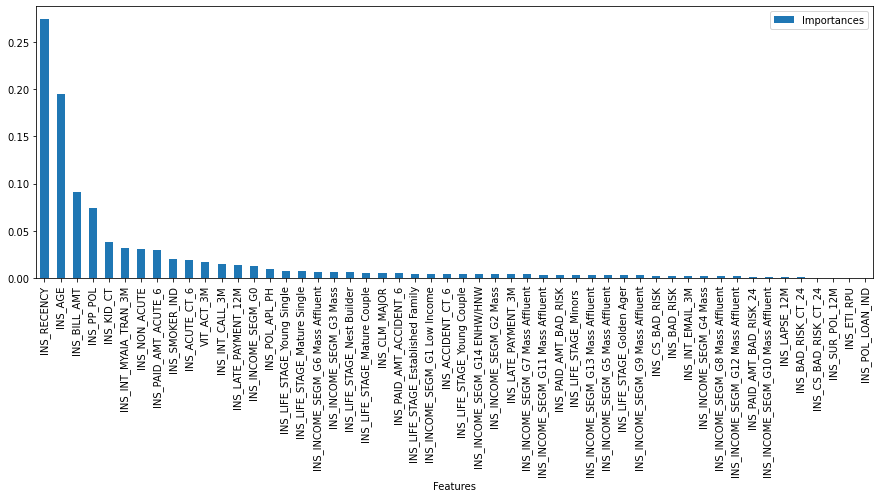

In [42]:
final_df.plot(kind='bar',x='Features',y='Importances',figsize=(15,5))

In [45]:
lst2 = final_df.Features[:-6].values
lst2

array(['INS_RECENCY', 'INS_AGE', 'INS_BILL_AMT', 'INS_PP_POL',
       'INS_KID_CT', 'INS_INT_MYAIA_TRAN_3M', 'INS_NON_ACUTE',
       'INS_PAID_AMT_ACUTE_6', 'INS_SMOKER_IND', 'INS_ACUTE_CT_6',
       'VIT_ACT_3M', 'INS_INT_CALL_3M', 'INS_LATE_PAYMENT_12M',
       'INS_INCOME_SEGM_G0', 'INS_POL_APL_PH',
       'INS_LIFE_STAGE_Young Single', 'INS_LIFE_STAGE_Mature Single',
       'INS_INCOME_SEGM_G6 Mass Affluent', 'INS_INCOME_SEGM_G3 Mass',
       'INS_LIFE_STAGE_Nest Builder', 'INS_LIFE_STAGE_Mature Couple',
       'INS_CLM_MAJOR', 'INS_PAID_AMT_ACCIDENT_6',
       'INS_LIFE_STAGE_Established Family',
       'INS_INCOME_SEGM_G1 Low Income', 'INS_ACCIDENT_CT_6',
       'INS_LIFE_STAGE_Young Couple', 'INS_INCOME_SEGM_G14 ENHW/HNW',
       'INS_INCOME_SEGM_G2 Mass', 'INS_LATE_PAYMENT_3M',
       'INS_INCOME_SEGM_G7 Mass Affluent',
       'INS_INCOME_SEGM_G11 Mass Affluent', 'INS_PAID_AMT_BAD_RISK',
       'INS_LIFE_STAGE_Minors ', 'INS_INCOME_SEGM_G13 Mass Affluent',
       'INS_INCOME_SE

In [46]:
df_train2[lst2].head()

INS_RECENCY  INS_AGE  INS_BILL_AMT  INS_PP_POL  INS_KID_CT  \
0           23      5.0       6000.00           1           0   
1           20     15.0       1521.50           1           0   
2           79     54.0          0.00           3           1   
3           77     37.0     126801.86           3           0   
4           24     22.0          0.00           1           0   

   INS_INT_MYAIA_TRAN_3M  INS_NON_ACUTE  INS_PAID_AMT_ACUTE_6  INS_SMOKER_IND  \
0                      0              2                   0.0               0   
1                      0              0                1521.5               0   
2                      0              0                   0.0               1   
3                      0             11                   0.0               1   
4                      0              0                   0.0               0   

   INS_ACUTE_CT_6  ...  INS_LIFE_STAGE_Golden Ager  \
0               0  ...                           0   
1               2  ...                           0   
2               0  ...                           0   
3               0  ...                           0   
4               0  ...                           0   

   INS_INCOME_SEGM_G9 Mass Affluent  INS_CS_BAD_RISK  INS_BAD_RISK  \
0                                 0                0             0   
1                                 0                0             0   
2                                 0                0             0   
3                                 0                0             0   
4                                 0                0             0   

   INS_INT_EMAIL_3M  INS_INCOME_SEGM_G4 Mass  \
0                 0                        0   
1                 0                        0   
2                 0                        0   
3                 0                        0   
4                 0                        0   

   INS_INCOME_SEGM_G8 Mass Affluent  INS_INCOME_SEGM_G12 Mass Affluent  \
0                                 0                                  0   
1                                 0                                  0   
2                                 0                                  0   
3                                 0                                  0   
4                                 0                                  0   

   INS_PAID_AMT_BAD_RISK_24  INS_INCOME_SEGM_G10 Mass Affluent  
0                       0.0                                  0  
1                       0.0                                  0  
2                       0.0                                  0  
3                       0.0                                  0  
4                       0.0                                  0  

[5 rows x 46 columns]

In [47]:
X.corr()

INS_NON_ACUTE  INS_CLM_MAJOR   INS_AGE  \
INS_NON_ACUTE                           1.000000       0.198518  0.192308   
INS_CLM_MAJOR                           0.198518       1.000000  0.086567   
INS_AGE                                 0.192308       0.086567  1.000000   
INS_ACUTE_CT_6                          0.078850      -0.012580 -0.235740   
INS_PAID_AMT_ACUTE_6                    0.079492       0.009170 -0.087712   
INS_ACCIDENT_CT_6                       0.051246       0.002454  0.002120   
INS_PAID_AMT_ACCIDENT_6                 0.031154       0.004208  0.007178   
INS_INT_CALL_3M                         0.000360       0.009386  0.022226   
INS_KID_CT                              0.096180       0.069473  0.392896   
INS_SMOKER_IND                          0.079580       0.076736  0.332863   
INS_LAPSE_12M                          -0.008301      -0.003147 -0.004733   
INS_SUR_POL_12M                        -0.004326      -0.002077 -0.007776   
INS_PP_POL                              0.057036       0.047249  0.171533   
INS_ETI_RPU                            -0.000752       0.000383  0.006735   
INS_POL_APL_PH                         -0.006133      -0.000610 -0.018420   
INS_POL_LOAN_IND                        0.002837       0.007258  0.004769   
INS_LATE_PAYMENT_3M                    -0.037160      -0.014460 -0.007886   
INS_LATE_PAYMENT_12M                   -0.063904      -0.024646 -0.103945   
INS_RECENCY                             0.073374       0.030245  0.330199   
INS_BILL_AMT                            0.472575       0.156741  0.133293   
INS_BAD_RISK                            0.741370       0.259550  0.136389   
INS_BAD_RISK_CT_24                      0.555731       0.248283  0.101092   
INS_PAID_AMT_BAD_RISK                   0.502179       0.356350  0.127919   
INS_PAID_AMT_BAD_RISK_24                0.332478       0.306537  0.080083   
INS_CS_BAD_RISK                         0.004842       0.030942  0.027934   
INS_CS_BAD_RISK_CT_24                   0.003797       0.030220  0.020871   
VIT_ACT_3M                             -0.012327       0.009952  0.009605   
INS_INT_EMAIL_3M                       -0.000828       0.004612  0.002268   
INS_INT_MYAIA_TRAN_3M                   0.004226       0.032827  0.026318   
INS_LIFE_STAGE_Established Family      -0.012916       0.027229  0.257931   
INS_LIFE_STAGE_Golden Ager              0.184654       0.057801  0.611372   
INS_LIFE_STAGE_Mature Couple           -0.009141      -0.004663  0.105001   
INS_LIFE_STAGE_Mature Single            0.010257       0.001166  0.049230   
INS_LIFE_STAGE_Minors                  -0.052237      -0.037022 -0.680547   
INS_LIFE_STAGE_Nest Builder            -0.026803       0.001329  0.032769   
INS_LIFE_STAGE_Young Couple            -0.035630      -0.016908 -0.066781   
INS_LIFE_STAGE_Young Single            -0.092271      -0.040229 -0.361688   
INS_INCOME_SEGM_G0                     -0.011034       0.000908 -0.164210   
INS_INCOME_SEGM_G1 Low Income           0.032946       0.010800  0.203346   
INS_INCOME_SEGM_G10 Mass Affluent       0.000960       0.003690  0.025110   
INS_INCOME_SEGM_G11 Mass Affluent      -0.002380       0.000772  0.023468   
INS_INCOME_SEGM_G12 Mass Affluent       0.002455      -0.001001  0.026609   
INS_INCOME_SEGM_G13 Mass Affluent       0.002703       0.011745  0.042355   
INS_INCOME_SEGM_G14 ENHW/HNW            0.024282       0.010166  0.078184   
INS_INCOME_SEGM_G2 Mass                -0.020622      -0.008569 -0.028200   
INS_INCOME_SEGM_G3 Mass                -0.011514      -0.014642 -0.038213   
INS_INCOME_SEGM_G4 Mass                -0.009744      -0.004895 -0.005581   
INS_INCOME_SEGM_G5 Mass Affluent       -0.010387      -0.005000 -0.000787   
INS_INCOME_SEGM_G6 Mass Affluent       -0.002432      -0.006350  0.013572   
INS_INCOME_SEGM_G7 Mass Affluent       -0.003467       0.000903  0.021203   
INS_INCOME_SEGM_G8 Mass Affluent        0.000186      -0.001917  0.020203   
INS_INCOME_SEGM_G9 Mass Affluen

In [48]:
#import seaborn as sns
#plt.figure (figsize= (12,12)) 
#sns.heatmap(X.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

In [49]:
interactions = df_train2[lst]
interactions.head()

FLG_21  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
0     0.0          0.0             0.0           0.000000   
1     0.0          0.0             0.0           0.000000   
2     0.0          0.0             0.0           5.550879   
3     0.0          0.0             0.0           0.000000   
4     0.0          0.0             0.0           0.000000   

   FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
0                0.000000      0.015241         0.000000   
1                0.000000      0.000000         0.044651   
2                0.000000      0.000000         0.000000   
3                0.000000      0.022862         0.000000   
4                0.019773      0.022862         0.000000   

   FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  FLG_CALL_TRIGGER  
0                    0.0                0.0              0.0               0.0  
1                    0.0                0.0              0.0               0.0  
2                    0.0                0.0              0.0               0.0  
3                    0.0                0.0              0.0               0.0  
4                    0.0                0.0              0.0               0.0

In [ ]:
### Interaction Matrix - Scale
# Getting the Customer's transaction for every material interms of sales quantity
#interactions = cust_grouped.groupby(['Customer ID', 'Material'])['Qty'].sum().unstack().fillna(0)
interactions = df_train2[lst]
# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
interactions_scaled = minmaxscaler.fit_transform(interactions)
interactions_scaled = pd.DataFrame(interactions_scaled)

## The scaled matrix lost the index (customer) and column (item) information
## we re-append the customer ID and the material into the DataFrame's index and column respectively
interactions_scaled.index = interactions.index
interactions_scaled.columns = interactions.columns


In [50]:

### Interaction Matrix - not scaling
# Getting the Customer's transaction for every material interms of sales quantity
#interactions = cust_grouped.groupby(['Customer ID', 'Material'])['Qty'].sum().unstack().fillna(0)
interactions = df_train[lst]
# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
#minmaxscaler = preprocessing.MinMaxScaler()
#interactions_scaled = minmaxscaler.fit_transform(interactions)
interactions_scaled = interactions.copy()
interactions_scaled = pd.DataFrame(interactions_scaled)

## The scaled matrix lost the index (customer) and column (item) information
## we re-append the customer ID and the material into the DataFrame's index and column respectively
interactions_scaled.index = interactions.index
interactions_scaled.columns = interactions.columns

In [51]:
interactions.describe()

FLG_21    FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
count  136708.000000  136708.000000   136708.000000      136708.000000   
mean        0.024173       0.061160        0.021190           0.063287   
std         0.108852       0.424473        0.038374           0.534560   
min         0.000000       0.000000        0.000000           0.000000   
25%         0.000000       0.000000        0.000000           0.000000   
50%         0.000000       0.000000        0.000000           0.000000   
75%         0.000000       0.000000        0.035300           0.000000   
max         0.536822       4.384417        0.105899           5.550879   

       FLG_POL_ANNIVERSARY_1M   FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
count           136708.000000  136708.000000    136708.000000   
mean                 0.004992       0.007061         0.008280   
std                  0.008893       0.011179         0.015929   
min                  0.000000       0.000000         0.000000   
25%                  0.000000       0.000000         0.000000   
50%                  0.000000       0.000000         0.000000   
75%                  0.009886       0.022862         0.000000   
max                  0.039545       0.045724         0.044651   

       FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  \
count          136708.000000      136708.000000    136708.000000   
mean                0.023088           0.026448         0.021375   
std                 0.252028           0.241005         0.509363   
min                 0.000000           0.000000         0.000000   
25%                 0.000000           0.000000         0.000000   
50%                 0.000000           0.000000         0.000000   
75%                 0.000000           0.000000         0.000000   
max                 3.576791           2.719694        14.843315   

       FLG_CALL_TRIGGER  
count     136708.000000  
mean           0.046392  
std            0.235607  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.452194

In [52]:
interactions.sum()

FLG_21                    3304.688478
FLG_MARRIED               8361.051428
FLG_LIFE_STAGE            2896.815057
FLG_INCOME_CHANGE         8651.785147
FLG_POL_ANNIVERSARY_1M     682.501279
FLG_BIRTHDAY               965.226847
FLG_CLM_TRIGGER           1131.888069
FLG_NON_ACUTE_CLM_FAM     3156.279774
FLG_ACUTE_CLM_FAM         3615.697125
FLG_ACC_CLM_FAM           2922.154043
FLG_CALL_TRIGGER          6342.165872
dtype: float64

In [53]:
interactions.mean()

FLG_21                    0.024173
FLG_MARRIED               0.061160
FLG_LIFE_STAGE            0.021190
FLG_INCOME_CHANGE         0.063287
FLG_POL_ANNIVERSARY_1M    0.004992
FLG_BIRTHDAY              0.007061
FLG_CLM_TRIGGER           0.008280
FLG_NON_ACUTE_CLM_FAM     0.023088
FLG_ACUTE_CLM_FAM         0.026448
FLG_ACC_CLM_FAM           0.021375
FLG_CALL_TRIGGER          0.046392
dtype: float64

In [54]:
interactions_scaled = pd.concat([df_train2['INS_ID'],interactions_scaled],axis=1)

In [55]:
customer_features = df_train2[lst2]

In [56]:
#customer_features = pd.concat([df_train2['INS_ID'],customer_features, df_flags],axis=1)
customer_features = pd.concat([df_train2['INS_ID'],customer_features],axis=1)

In [57]:
#customer_features = pd.concat([df_train2['INS_ID'],customer_features],axis=1)
#df_flags.head()

In [58]:
#customer_features = df_train2[final_df.Features[:10]]
customer_features.head()

INS_ID  INS_RECENCY  INS_AGE  INS_BILL_AMT  INS_PP_POL  INS_KID_CT  \
0  282051           23      5.0       6000.00           1           0   
1  299865           20     15.0       1521.50           1           0   
2  111312           79     54.0          0.00           3           1   
3  804673           77     37.0     126801.86           3           0   
4  571688           24     22.0          0.00           1           0   

   INS_INT_MYAIA_TRAN_3M  INS_NON_ACUTE  INS_PAID_AMT_ACUTE_6  INS_SMOKER_IND  \
0                      0              2                   0.0               0   
1                      0              0                1521.5               0   
2                      0              0                   0.0               1   
3                      0             11                   0.0               1   
4                      0              0                   0.0               0   

   ...  INS_LIFE_STAGE_Golden Ager  INS_INCOME_SEGM_G9 Mass Affluent  \
0  ...                           0                                 0   
1  ...                           0                                 0   
2  ...                           0                                 0   
3  ...                           0                                 0   
4  ...                           0                                 0   

   INS_CS_BAD_RISK  INS_BAD_RISK  INS_INT_EMAIL_3M  INS_INCOME_SEGM_G4 Mass  \
0                0             0                 0                        0   
1                0             0                 0                        0   
2                0             0                 0                        0   
3                0             0                 0                        0   
4                0             0                 0                        0   

   INS_INCOME_SEGM_G8 Mass Affluent  INS_INCOME_SEGM_G12 Mass Affluent  \
0                                 0                                  0   
1                                 0                                  0   
2                                 0                                  0   
3                                 0                                  0   
4                                 0                                  0   

   INS_PAID_AMT_BAD_RISK_24  INS_INCOME_SEGM_G10 Mass Affluent  
0                       0.0                                  0  
1                       0.0                                  0  
2                       0.0                                  0  
3                       0.0                                  0  
4                       0.0                                  0  

[5 rows x 47 columns]

In [59]:
item_category_scaled = interactions
item_category_scaled.shape

(136708, 11)

In [92]:
item_category_scaled.describe()

FLG_21    FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
count  136708.000000  136708.000000   136708.000000      136708.000000   
mean        0.024173       0.061160        0.021190           0.063287   
std         0.108852       0.424473        0.038374           0.534560   
min         0.000000       0.000000        0.000000           0.000000   
25%         0.000000       0.000000        0.000000           0.000000   
50%         0.000000       0.000000        0.000000           0.000000   
75%         0.000000       0.000000        0.035300           0.000000   
max         0.536822       4.384417        0.105899           5.550879   

       FLG_POL_ANNIVERSARY_1M   FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
count           136708.000000  136708.000000    136708.000000   
mean                 0.004992       0.007061         0.008280   
std                  0.008893       0.011179         0.015929   
min                  0.000000       0.000000         0.000000   
25%                  0.000000       0.000000         0.000000   
50%                  0.000000       0.000000         0.000000   
75%                  0.009886       0.022862         0.000000   
max                  0.039545       0.045724         0.044651   

       FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  \
count          136708.000000      136708.000000    136708.000000   
mean                0.023088           0.026448         0.021375   
std                 0.252028           0.241005         0.509363   
min                 0.000000           0.000000         0.000000   
25%                 0.000000           0.000000         0.000000   
50%                 0.000000           0.000000         0.000000   
75%                 0.000000           0.000000         0.000000   
max                 3.576791           2.719694        14.843315   

       FLG_CALL_TRIGGER  
count     136708.000000  
mean           0.046392  
std            0.235607  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.452194

In [52]:
item_category_scaled.loc[item_category_scaled.FLG_INCOME_CHANGE > 0.023].shape

(2236, 11)

In [53]:
item_category_scaled.loc[item_category_scaled.FLG_INCOME_CHANGE > 0.0].shape

(2236, 11)

In [54]:
item_category_scaled.loc[item_category_scaled.FLG_BIRTHDAY > 0.0].shape

(42033, 11)

In [45]:
item_category_scaled.loc[item_category_scaled.FLG_POL_ANNIVERSARY_1M > 0.023].shape

(1542, 11)

In [46]:
item_category_scaled.loc[item_category_scaled.FLG_POL_ANNIVERSARY_1M > 0.0].shape

(34984, 11)

In [ ]:
valid_cutoff = 0
cutoff = df_train2.shape[0] - valid_cutoff
cutoff

In [ ]:
interaction_f = sparse.coo_matrix(interactions_scaled.iloc[:-valid_cutoff,1:])
interaction_f1 = sparse.coo_matrix(interactions_scaled.iloc[cutoff:,1:])

user_f  = sparse.coo_matrix(customer_features.iloc[:-valid_cutoff,1:]) 
user_f1  = sparse.coo_matrix(customer_features.iloc[cutoff:,1:]) 

#item_f  = sparse.coo_matrix(df_flags.iloc[:-valid_cutoff,:])
item_f  = sparse.identity(item_category_scaled.shape[1])

In [60]:
interaction_f = sparse.coo_matrix(interactions_scaled.iloc[:,1:])
interaction_f1 = sparse.coo_matrix(interactions_scaled.iloc[:,1:])

user_f  = sparse.coo_matrix(customer_features.iloc[:,1:]) 
user_f1  = sparse.coo_matrix(customer_features.iloc[:,1:]) 

#item_f  = sparse.coo_matrix(df_flags)
item_f  = sparse.identity(item_category_scaled.shape[1])

In [ ]:
#interaction_f = interaction_f2.multiply(interaction_f2 > 0.02)

In [ ]:
#interaction_f = sparse.coo_matrix(interactions_scaled.iloc[:,1:])
#interaction_f1 = sparse.coo_matrix(interactions_scaled.iloc[9900:,:])

#user_f  = sparse.coo_matrix(customer_features.iloc[:,1:]) 
#user_f1  = sparse.coo_matrix(customer_features.iloc[9900:,:]) 

#item_f  = sparse.coo_matrix(item_category_scaled)
#item_f  = sparse.identity(item_category_scaled.shape[1])

In [61]:
interaction_f

<136708x11 sparse matrix of type '<class 'numpy.float64'>'
	with 165264 stored elements in COOrdinate format>

In [62]:
interaction_f1

<136708x11 sparse matrix of type '<class 'numpy.float64'>'
	with 165264 stored elements in COOrdinate format>

In [63]:
user_f

<136708x46 sparse matrix of type '<class 'numpy.float64'>'
	with 1022069 stored elements in COOrdinate format>

In [64]:
user_f1

<136708x46 sparse matrix of type '<class 'numpy.float64'>'
	with 1022069 stored elements in COOrdinate format>

In [65]:
item_f

<11x11 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements (1 diagonals) in DIAgonal format>

In [66]:
matrix_size = interaction_f.shape[0]*interaction_f.shape[1] # Number of possible interactions in the matrix
num_flags = len(interaction_f.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_flags/matrix_size))
sparsity

89.01015302688943

In [ ]:
#For collaborative filtering to work, the maximum sparsity you could get away with would probably 
#be about 99.5% or so. We are well below this, so we should be able to get decent results.

### TensorREC

In [67]:
def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [96]:
# Split train / test > 80:20
#42 = 77-78
np.random.seed(1234)
mask_size = len(interaction_f.data)

### use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([False,  True,  True, ...,  True,  True,  True])

In [97]:
# Create a masked train and test dataset of the interaction features
train_interactions1, test_interactions1 = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
user_features1  = user_f1
item_features = item_f

In [98]:
train_interactions = train_interactions1.multiply(train_interactions1 > 0.023) #0.0205

In [99]:
train_interactions

<136708x11 sparse matrix of type '<class 'numpy.float64'>'
	with 71866 stored elements in Compressed Sparse Row format>

In [100]:
test_interactions = test_interactions1.multiply(test_interactions1 > 0.023)

In [101]:
test_interactions

<136708x11 sparse matrix of type '<class 'numpy.float64'>'
	with 17915 stored elements in Compressed Sparse Row format>

In [102]:
import tensorflow as tf
from errors import (
    ModelNotBiasedException, ModelNotFitException, ModelWithoutAttentionException, BatchNonSparseInputException,
    TfVersionException
)
from input_utils import create_tensorrec_iterator, get_dimensions_from_tensorrec_dataset
from loss_graphs import AbstractLossGraph, RMSELossGraph
from prediction_graphs import AbstractPredictionGraph, DotProductPredictionGraph
from recommendation_graphs import (
    project_biases, split_sparse_tensor_indices, bias_prediction_dense, bias_prediction_serial, rank_predictions,
    densify_sampled_item_predictions, collapse_mixture_of_tastes, predict_similar_items
)
from representation_graphs import AbstractRepresentationGraph, LinearRepresentationGraph
from session_management import get_session
from util import sample_items, calculate_batched_alpha, datasets_from_raw_input

In [103]:
class TensorRec(object):

    def __init__(self,
                 n_components=100,
                 n_tastes=1,
                 user_repr_graph=LinearRepresentationGraph(),
                 item_repr_graph=LinearRepresentationGraph(),
                 attention_graph=None,
                 prediction_graph=DotProductPredictionGraph(),
                 loss_graph=RMSELossGraph(),
                 biased=True,):
        """
        A TensorRec recommendation model.
        :param n_components: Integer
        The dimension of a single output of the representation function. Must be >= 1.
        :param n_tastes: Integer
        The number of tastes/reprs to be calculated for each user. Must be >= 1.
        :param user_repr_graph: AbstractRepresentationGraph
        An object which inherits AbstractRepresentationGraph that contains a method to calculate user representations.
        See tensorrec.representation_graphs for examples.
        :param item_repr_graph: AbstractRepresentationGraph
        An object which inherits AbstractRepresentationGraph that contains a method to calculate item representations.
        See tensorrec.representation_graphs for examples.
        :param attention_graph: AbstractRepresentationGraph or None
        Optional. An object which inherits AbstractRepresentationGraph that contains a method to calculate user
        attention. Any valid repr_graph is also a valid attention graph. If None, no attention process will be applied.
        :param prediction_graph: AbstractPredictionGraph
        An object which inherits AbstractPredictionGraph that contains a method to calculate predictions from a pair of
        user/item reprs.
        See tensorrec.prediction_graphs for examples.
        :param loss_graph: AbstractLossGraph
        An object which inherits AbstractLossGraph that contains a method to calculate the loss function.
        See tensorrec.loss_graphs for examples.
        :param biased: bool
        If True, a bias value will be calculated for every user feature and item feature.
        """

        # Check TensorFlow version
        major, minor, patch = tf.__version__.split(".")
        if int(major) < 1 or int(major) == 1 and int(minor) < 7:
            raise TfVersionException(tf_version=tf.__version__)

        # Arg Check
        if (n_components is None) or (n_tastes is None) or (user_repr_graph is None) or (item_repr_graph is None) \
                or (prediction_graph is None) or (loss_graph is None):
            raise ValueError("All arguments to TensorRec() must be non-None")
        if n_components < 1:
            raise ValueError("n_components must be >= 1")
        if n_tastes < 1:
            raise ValueError("n_tastes must be >= 1")
        if not isinstance(user_repr_graph, AbstractRepresentationGraph):
            raise ValueError("user_repr_graph must inherit AbstractRepresentationGraph")
        if not isinstance(item_repr_graph, AbstractRepresentationGraph):
            raise ValueError("item_repr_graph must inherit AbstractRepresentationGraph")
        if not isinstance(prediction_graph, AbstractPredictionGraph):
            raise ValueError("prediction_graph must inherit AbstractPredictionGraph")
        if not isinstance(loss_graph, AbstractLossGraph):
            raise ValueError("loss_graph must inherit AbstractLossGraph")
        if attention_graph is not None:
            if not isinstance(attention_graph, AbstractRepresentationGraph):
                raise ValueError("attention_graph must be None or inherit AbstractRepresentationGraph")
            if n_tastes == 1:
                raise ValueError("attention_graph must be None if n_tastes == 1")

        self.n_components = n_components
        self.n_tastes = n_tastes
        self.user_repr_graph_factory = user_repr_graph
        self.item_repr_graph_factory = item_repr_graph
        self.attention_graph_factory = attention_graph
        self.prediction_graph_factory = prediction_graph
        self.loss_graph_factory = loss_graph
        self.biased = biased

        # A list of the attr names of every graph hook attr
        self.graph_tensor_hook_attr_names = [

            # Top-level API nodes
            'tf_user_representation', 'tf_item_representation', 'tf_prediction_serial', 'tf_prediction', 'tf_rankings',
            'tf_predict_similar_items', 'tf_rank_similar_items',

            # Training nodes
            'tf_basic_loss', 'tf_weight_reg_loss', 'tf_loss',

            # Feed placeholders
            'tf_learning_rate', 'tf_alpha', 'tf_sample_indices', 'tf_n_sampled_items', 'tf_similar_items_ids',
        ]
        if self.biased:
            self.graph_tensor_hook_attr_names += ['tf_projected_user_biases', 'tf_projected_item_biases']
        if self.attention_graph_factory is not None:
            self.graph_tensor_hook_attr_names += ['tf_user_attention_representation']

        self.graph_operation_hook_attr_names = [
            # AdamOptimizer
            'tf_optimizer',
        ]
        self.graph_iterator_hook_attr_names = [
            # Input data iterators
            'tf_user_feature_iterator', 'tf_item_feature_iterator', 'tf_interaction_iterator',
        ]

        # Calling the break routine during __init__ creates all the attrs on the TensorRec object with an initial value
        # of None
        self._break_graph_hooks()

        # A map of every graph hook attr name to the node name after construction
        # Tensors and operations are stored separated because they are handled differently by TensorFlow
        self.graph_tensor_hook_node_names = {}
        self.graph_operation_hook_node_names = {}
        self.graph_iterator_hook_node_names = {}

    def _break_graph_hooks(self):
        for graph_tensor_hook_attr_name in self.graph_tensor_hook_attr_names:
            self.__setattr__(graph_tensor_hook_attr_name, None)
        for graph_operation_hook_attr_name in self.graph_operation_hook_attr_names:
            self.__setattr__(graph_operation_hook_attr_name, None)
        for graph_iterator_hook_attr_name in self.graph_iterator_hook_attr_names:
            self.__setattr__(graph_iterator_hook_attr_name, None)

    def _attach_graph_hooks(self):
        session = get_session()

        for graph_tensor_hook_attr_name in self.graph_tensor_hook_attr_names:
            graph_tensor_hook_node_name = self.graph_tensor_hook_node_names[graph_tensor_hook_attr_name]
            node = session.graph.get_tensor_by_name(name=graph_tensor_hook_node_name)
            self.__setattr__(graph_tensor_hook_attr_name, node)

        for graph_operation_hook_attr_name in self.graph_operation_hook_attr_names:
            graph_operation_hook_node_name = self.graph_operation_hook_node_names[graph_operation_hook_attr_name]
            node = session.graph.get_operation_by_name(name=graph_operation_hook_node_name)
            self.__setattr__(graph_operation_hook_attr_name, node)

        for graph_iterator_hook_attr_name in self.graph_iterator_hook_attr_names:
            iterator_resource_name, output_types, output_shapes, output_classes = \
                self.graph_iterator_hook_node_names[graph_iterator_hook_attr_name]
            iterator_resource = session.graph.get_tensor_by_name(name=iterator_resource_name)
            iterator = tf.compat.v1.data.Iterator(iterator_resource, None, output_types, output_shapes, output_classes)
            self.__setattr__(graph_iterator_hook_attr_name, iterator)

    def _record_graph_hook_names(self):

        # Record serializable node names/info for each graph hook
        for graph_tensor_hook_attr_name in self.graph_tensor_hook_attr_names:
            hook = self.__getattribute__(graph_tensor_hook_attr_name)
            self.graph_tensor_hook_node_names[graph_tensor_hook_attr_name] = hook.name

        for graph_operation_hook_attr_name in self.graph_operation_hook_attr_names:
            hook = self.__getattribute__(graph_operation_hook_attr_name)
            self.graph_operation_hook_node_names[graph_operation_hook_attr_name] = hook.name

        for graph_iterator_hook_attr_name in self.graph_iterator_hook_attr_names:
            hook = self.__getattribute__(graph_iterator_hook_attr_name)
            iterator_resource_name = hook._iterator_resource.name
            output_types = hook.output_types
            output_shapes = hook.output_shapes
            output_classes = hook.output_classes
            self.graph_iterator_hook_node_names[graph_iterator_hook_attr_name] = (
                iterator_resource_name, output_types, output_shapes, output_classes
            )

    def _create_batched_dataset_initializers(self, interactions, user_features, item_features, user_batch_size=None):

        if user_batch_size is not None:

            # Raise exception if interactions and user_features aren't sparse matrices
            if (not sp.issparse(interactions)) or (not sp.issparse(user_features)):
                raise BatchNonSparseInputException()

            # Coerce to CSR for fast batching
            if not isinstance(interactions, sp.csr_matrix):
                interactions = sp.csr_matrix(interactions)
            if not isinstance(user_features, sp.csr_matrix):
                user_features = sp.csr_matrix(user_features)

            n_users = user_features.shape[0]

            interactions_batched = []
            user_features_batched = []

            start_batch = 0
            while start_batch < n_users:

                # min() ensures that the batch bounds doesn't go past the end of the index
                end_batch = min(start_batch + user_batch_size, n_users)

                interactions_batched.append(interactions[start_batch:end_batch])
                user_features_batched.append(user_features[start_batch:end_batch])

                start_batch = end_batch

            # Overwrite the input with the new, batched input
            interactions = interactions_batched
            user_features = user_features_batched

        # TODO this is hand-wavy and begging for a cleaner refactor
        (int_ds, uf_ds, if_ds), (int_init, uf_init, if_init) = self._create_datasets_and_initializers(
            interactions=interactions, user_features=user_features, item_features=item_features
        )

        # Ensure that lengths make sense
        if len(int_init) != len(uf_init):
            raise ValueError('Number of batches in user_features and interactions must be equal.')
        if (len(if_init) > 1) and (len(if_init) != len(uf_init)):
            raise ValueError('Number of batches in item_features must be 1 or equal to the number of batches in '
                             'user_features.')

        # Cycle item features when zipping because there should only be one
        datasets = [ds_set for ds_set in zip(int_ds, uf_ds, cycle(if_ds))]
        initializers = [init_set for init_set in zip(int_init, uf_init, cycle(if_init))]

        return datasets, initializers

    def _create_datasets_and_initializers(self, interactions=None, user_features=None, item_features=None):

        datasets = []
        initializers = []

        if interactions is not None:
            interactions_datasets = datasets_from_raw_input(raw_input=interactions)
            interactions_initializers = [self.tf_interaction_iterator.make_initializer(dataset)
                                         for dataset in interactions_datasets]
            datasets.append(interactions_datasets)
            initializers.append(interactions_initializers)

        if user_features is not None:
            user_features_datasets = datasets_from_raw_input(raw_input=user_features)
            user_features_initializers = [self.tf_user_feature_iterator.make_initializer(dataset)
                                          for dataset in user_features_datasets]
            datasets.append(user_features_datasets)
            initializers.append(user_features_initializers)

        if item_features is not None:
            item_features_datasets = datasets_from_raw_input(raw_input=item_features)
            item_features_initializers = [self.tf_item_feature_iterator.make_initializer(dataset)
                                          for dataset in item_features_datasets]
            datasets.append(item_features_datasets)
            initializers.append(item_features_initializers)

        return datasets, initializers

    def _build_input_iterators(self):
        self.tf_user_feature_iterator = create_tensorrec_iterator(name='tf_user_feature_iterator')
        self.tf_item_feature_iterator = create_tensorrec_iterator(name='tf_item_feature_iterator')
        self.tf_interaction_iterator = create_tensorrec_iterator(name='tf_interaction_iterator')

    def _build_tf_graph(self, n_user_features, n_item_features):

        # Build placeholders
        self.tf_n_sampled_items = tf.compat.v1.placeholder('int64')
        self.tf_similar_items_ids = tf.compat.v1.placeholder('int64', [None])
        self.tf_learning_rate = tf.compat.v1.placeholder('float', None)
        self.tf_alpha = tf.compat.v1.placeholder('float', None)

        tf_user_feature_rows, tf_user_feature_cols, tf_user_feature_values, tf_n_users, _ = \
            self.tf_user_feature_iterator.get_next()
        tf_item_feature_rows, tf_item_feature_cols, tf_item_feature_values, tf_n_items, _ = \
            self.tf_item_feature_iterator.get_next()
        tf_interaction_rows, tf_interaction_cols, tf_interaction_values, _, _ = \
            self.tf_interaction_iterator.get_next()

        tf_user_feature_indices = tf.stack([tf_user_feature_rows, tf_user_feature_cols], axis=1)
        tf_item_feature_indices = tf.stack([tf_item_feature_rows, tf_item_feature_cols], axis=1)
        tf_interaction_indices = tf.stack([tf_interaction_rows, tf_interaction_cols], axis=1)

        # Construct the features and interactions as sparse matrices
        tf_user_features = tf.SparseTensor(tf_user_feature_indices, tf_user_feature_values,
                                           [tf_n_users, n_user_features])
        tf_item_features = tf.SparseTensor(tf_item_feature_indices, tf_item_feature_values,
                                           [tf_n_items, n_item_features])
        tf_interactions = tf.SparseTensor(tf_interaction_indices, tf_interaction_values,
                                          [tf_n_users, tf_n_items])

        # Construct the sampling py_func
        sample_items_partial = partial(sample_items, replace=self.loss_graph_factory.is_sampled_with_replacement)
        self.tf_sample_indices = tf.compat.v1.py_func(func=sample_items_partial,
                                            inp=[tf_n_items, tf_n_users, self.tf_n_sampled_items],
                                            Tout=tf.int64)
        self.tf_sample_indices.set_shape([None, None])

        # Collect the weights for regularization
        tf_weights = []

        # Build the item representations
        self.tf_item_representation, item_weights = \
            self.item_repr_graph_factory.connect_representation_graph(tf_features=tf_item_features,
                                                                      n_components=self.n_components,
                                                                      n_features=n_item_features,
                                                                      node_name_ending='item')
        tf_weights.extend(item_weights)

        tf_x_user, tf_x_item = split_sparse_tensor_indices(tf_sparse_tensor=tf_interactions, n_dimensions=2)
        tf_transposed_sample_indices = tf.transpose(a=self.tf_sample_indices)
        tf_x_user_sample = tf_transposed_sample_indices[0]
        tf_x_item_sample = tf_transposed_sample_indices[1]

        # These lists will hold the reprs and predictions for each taste
        tastes_tf_user_representations = []
        tastes_tf_predictions = []
        tastes_tf_prediction_serials = []
        tastes_tf_sample_prediction_serials = []

        # If this model does not use attention, Nones are used as sentinels in place of the attentions
        if self.attention_graph_factory is not None:
            tastes_tf_attentions = []
            tastes_tf_attention_serials = []
            tastes_tf_sample_attention_serials = []
            tastes_tf_attention_representations = []
        else:
            tastes_tf_attentions = None
            tastes_tf_attention_serials = None
            tastes_tf_sample_attention_serials = None
            tastes_tf_attention_representations = None

        # Build n_tastes user representations and predictions
        for taste in range(self.n_tastes):
            tf_user_representation, user_weights = \
                self.user_repr_graph_factory.connect_representation_graph(tf_features=tf_user_features,
                                                                          n_components=self.n_components,
                                                                          n_features=n_user_features,
                                                                          node_name_ending='user_{}'.format(taste))
            tastes_tf_user_representations.append(tf_user_representation)
            tf_weights.extend(user_weights)

            # Connect attention, if applicable
            if self.attention_graph_factory is not None:
                tf_attention_representation, attention_weights = \
                    self.attention_graph_factory.connect_representation_graph(tf_features=tf_user_features,
                                                                              n_components=self.n_components,
                                                                              n_features=n_user_features,
                                                                              node_name_ending='attn_{}'.format(taste))
                tf_weights.extend(attention_weights)

                tf_attention = self.prediction_graph_factory.connect_dense_prediction_graph(
                    tf_user_representation=tf_attention_representation,
                    tf_item_representation=self.tf_item_representation
                )
                tf_attention_serial = self.prediction_graph_factory.connect_serial_prediction_graph(
                    tf_user_representation=tf_attention_representation,
                    tf_item_representation=self.tf_item_representation,
                    tf_x_user=tf_x_user,
                    tf_x_item=tf_x_item,
                )
                tf_sample_attention_serial = self.prediction_graph_factory.connect_serial_prediction_graph(
                    tf_user_representation=tf_user_representation,
                    tf_item_representation=self.tf_item_representation,
                    tf_x_user=tf_x_user_sample,
                    tf_x_item=tf_x_item_sample,
                )

                tastes_tf_attentions.append(tf_attention)
                tastes_tf_attention_serials.append(tf_attention_serial)
                tastes_tf_sample_attention_serials.append(tf_sample_attention_serial)
                tastes_tf_attention_representations.append(tf_attention_representation)

            # Connect the configurable prediction graphs for each taste
            tf_prediction = self.prediction_graph_factory.connect_dense_prediction_graph(
                tf_user_representation=tf_user_representation,
                tf_item_representation=self.tf_item_representation
            )
            tf_prediction_serial = self.prediction_graph_factory.connect_serial_prediction_graph(
                tf_user_representation=tf_user_representation,
                tf_item_representation=self.tf_item_representation,
                tf_x_user=tf_x_user,
                tf_x_item=tf_x_item,
            )
            tf_sample_predictions_serial = self.prediction_graph_factory.connect_serial_prediction_graph(
                tf_user_representation=tf_user_representation,
                tf_item_representation=self.tf_item_representation,
                tf_x_user=tf_x_user_sample,
                tf_x_item=tf_x_item_sample,
            )

            # Append to tastes
            tastes_tf_predictions.append(tf_prediction)
            tastes_tf_prediction_serials.append(tf_prediction_serial)
            tastes_tf_sample_prediction_serials.append(tf_sample_predictions_serial)

        # If attention is in the graph, build the API node
        if self.attention_graph_factory is not None:
            self.tf_user_attention_representation = tf.stack(tastes_tf_attention_representations)

        self.tf_user_representation = tf.stack(tastes_tf_user_representations)
        self.tf_prediction = collapse_mixture_of_tastes(
            tastes_predictions=tastes_tf_predictions,
            tastes_attentions=tastes_tf_attentions
        )
        self.tf_prediction_serial = collapse_mixture_of_tastes(
            tastes_predictions=tastes_tf_prediction_serials,
            tastes_attentions=tastes_tf_attention_serials
        )
        tf_sample_predictions_serial = collapse_mixture_of_tastes(
            tastes_predictions=tastes_tf_sample_prediction_serials,
            tastes_attentions=tastes_tf_sample_attention_serials
        )

        # Add biases, if this is a biased estimator
        if self.biased:
            tf_user_feature_biases, self.tf_projected_user_biases = project_biases(
                tf_features=tf_user_features, n_features=n_user_features
            )
            tf_item_feature_biases, self.tf_projected_item_biases = project_biases(
                tf_features=tf_item_features, n_features=n_item_features
            )

            tf_weights.append(tf_user_feature_biases)
            tf_weights.append(tf_item_feature_biases)

            self.tf_prediction = bias_prediction_dense(
                tf_prediction=self.tf_prediction,
                tf_projected_user_biases=self.tf_projected_user_biases,
                tf_projected_item_biases=self.tf_projected_item_biases)

            self.tf_prediction_serial = bias_prediction_serial(
                tf_prediction_serial=self.tf_prediction_serial,
                tf_projected_user_biases=self.tf_projected_user_biases,
                tf_projected_item_biases=self.tf_projected_item_biases,
                tf_x_user=tf_x_user,
                tf_x_item=tf_x_item)

            tf_sample_predictions_serial = bias_prediction_serial(
                tf_prediction_serial=tf_sample_predictions_serial,
                tf_projected_user_biases=self.tf_projected_user_biases,
                tf_projected_item_biases=self.tf_projected_item_biases,
                tf_x_user=tf_x_user_sample,
                tf_x_item=tf_x_item_sample)

        tf_interactions_serial = tf_interactions.values

        # Construct API nodes
        self.tf_rankings = rank_predictions(tf_prediction=self.tf_prediction)
        self.tf_predict_similar_items = predict_similar_items(prediction_graph_factory=self.prediction_graph_factory,
                                                              tf_item_representation=self.tf_item_representation,
                                                              tf_similar_items_ids=self.tf_similar_items_ids)
        self.tf_rank_similar_items = rank_predictions(tf_prediction=self.tf_predict_similar_items)

        # Compose loss function args
        # This composition is for execution safety: it prevents loss functions that are incorrectly configured from
        # having visibility of certain nodes.
        loss_graph_kwargs = {
            'tf_prediction_serial': self.tf_prediction_serial,
            'tf_interactions_serial': tf_interactions_serial,
            'tf_interactions': tf_interactions,
            'tf_n_users': tf_n_users,
            'tf_n_items': tf_n_items,
        }
        if self.loss_graph_factory.is_dense:
            loss_graph_kwargs.update({
                'tf_prediction': self.tf_prediction,
                'tf_rankings': self.tf_rankings,
            })
        if self.loss_graph_factory.is_sample_based:
            tf_sample_predictions = densify_sampled_item_predictions(
                tf_sample_predictions_serial=tf_sample_predictions_serial,
                tf_n_sampled_items=self.tf_n_sampled_items,
                tf_n_users=tf_n_users,
            )
            loss_graph_kwargs.update({'tf_sample_predictions': tf_sample_predictions,
                                      'tf_n_sampled_items': self.tf_n_sampled_items})

        # Build loss graph
        self.tf_basic_loss = self.loss_graph_factory.connect_loss_graph(**loss_graph_kwargs)

        self.tf_weight_reg_loss = sum(tf.nn.l2_loss(weights) for weights in tf_weights)
        self.tf_loss = self.tf_basic_loss + (self.tf_alpha * self.tf_weight_reg_loss)
        self.tf_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.tf_learning_rate).minimize(self.tf_loss)

        # Record the new node names
        self._record_graph_hook_names()

    def fit(self, interactions, user_features, item_features, epochs=100, learning_rate=0.1, alpha=0.00001,
            verbose=False, user_batch_size=None, n_sampled_items=None):
        """
        Constructs the TensorRec graph and fits the model.
        :param interactions: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of interactions of shape [n_users, n_items].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param epochs: Integer
        The number of epochs to fit the model.
        :param learning_rate: Float
        The learning rate of the model.
        :param alpha:
        The weight regularization loss coefficient.
        :param verbose: boolean
        If true, the model will print a number of status statements during fitting.
        :param user_batch_size: int or None
        The maximum number of users per batch, or None for all users.
        :param n_sampled_items: int or None
        The number of items to sample per user for use in loss functions. Must be non-None if
        self.loss_graph_factory.is_sample_based is True.
        """

        # Pass-through to fit_partial
        self.fit_partial(interactions=interactions,
                         user_features=user_features,
                         item_features=item_features,
                         epochs=epochs,
                         learning_rate=learning_rate,
                         alpha=alpha,
                         verbose=verbose,
                         user_batch_size=user_batch_size,
                         n_sampled_items=n_sampled_items)

    def fit_partial(self, interactions, user_features, item_features, epochs=1, learning_rate=0.1,
                    alpha=0.00001, verbose=False, user_batch_size=None, n_sampled_items=None):
        """
        Constructs the TensorRec graph and fits the model.
        :param interactions: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of interactions of shape [n_users, n_items].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param epochs: Integer
        The number of epochs to fit the model.
        :param learning_rate: Float
        The learning rate of the model.
        :param alpha:
        The weight regularization loss coefficient.
        :param verbose: boolean
        If true, the model will print a number of status statements during fitting.
        :param user_batch_size: int or None
        The maximum number of users per batch, or None for all users.
        :param n_sampled_items: int or None
        The number of items to sample per user for use in loss functions. Must be non-None if
        self.loss_graph_factory.is_sample_based is True.
        """

        session = get_session()

        # Arg checking
        if self.loss_graph_factory.is_sample_based:
            if (n_sampled_items is None) or (n_sampled_items <= 0):
                raise ValueError("n_sampled_items must be an integer >0")
        if (n_sampled_items is not None) and (not self.loss_graph_factory.is_sample_based):
            logging.warning('n_sampled_items was specified, but the loss graph is not sample-based')

        # Check if the iterators have been constructed. If not, build them.
        if self.tf_interaction_iterator is None:
            self._build_input_iterators()

        if verbose:
            logging.info('Processing interaction and feature data')

        dataset_sets, initializer_sets = self._create_batched_dataset_initializers(interactions=interactions,
                                                                                   user_features=user_features,
                                                                                   item_features=item_features,
                                                                                   user_batch_size=user_batch_size)

        # Check if the graph has been constructed by checking the dense prediction node
        # If it hasn't been constructed, initialize it
        if self.tf_prediction is None:

            # Check input dimensions
            first_batch = dataset_sets[0]
            _, n_user_features = get_dimensions_from_tensorrec_dataset(first_batch[1])
            _, n_item_features = get_dimensions_from_tensorrec_dataset(first_batch[2])

            # Numbers of features are either learned at fit time from the shape of these two matrices or specified at
            # TensorRec construction and cannot be changed.
            self._build_tf_graph(n_user_features=n_user_features, n_item_features=n_item_features)
            session.run(tf.compat.v1.global_variables_initializer())

        # Build the shared feed dict
        feed_dict = {self.tf_learning_rate: learning_rate,
                     self.tf_alpha: calculate_batched_alpha(num_batches=len(initializer_sets), alpha=alpha)}
        if self.loss_graph_factory.is_sample_based:
            feed_dict[self.tf_n_sampled_items] = n_sampled_items

        if verbose:
            logging.info('Beginning fitting')

        for epoch in range(epochs):
            for batch, initializers in enumerate(initializer_sets):

                session.run(initializers)
                if not verbose:
                    session.run(self.tf_optimizer, feed_dict=feed_dict)

                else:
                    _, loss, serial_predictions, wr_loss = session.run(
                        [self.tf_optimizer, self.tf_basic_loss, self.tf_prediction_serial, self.tf_weight_reg_loss],
                        feed_dict=feed_dict
                    )
                    mean_loss = np.mean(loss)
                    mean_pred = np.mean(serial_predictions)
                    weight_reg_l2_loss = alpha * wr_loss
                    logging.info('EPOCH {} BATCH {} loss = {}, weight_reg_l2_loss = {}, mean_pred = {}'.format(
                        epoch, batch, mean_loss, weight_reg_l2_loss, mean_pred
                    ))

    def predict(self, user_features, item_features):
        """
        Predict recommendation scores for the given users and items.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The predictions in an ndarray of shape [n_users, n_items]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=user_features,
                                                                 item_features=item_features)
        get_session().run(initializers)

        predictions = self.tf_prediction.eval(session=get_session())

        return predictions

    def predict_similar_items(self, item_features, item_ids, n_similar):
        """
        Predicts the most similar items to the given item_ids.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param item_ids: list or np.array
        The ids of the items of interest.
        E.g. [4, 8, 12] to get sims for items 4, 8, and 12.
        :param n_similar: int
        The number of similar items to get per item of interest.
        :return: list of lists of tuples
        The first level list corresponds to input arg item_ids.
        The second level list is of length n_similar and contains tuples of (item_id, score) for each similar item.
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_similar_items')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=None,
                                                                 item_features=item_features)
        get_session().run(initializers)

        feed_dict = {self.tf_similar_items_ids: np.array(item_ids)}
        sims = self.tf_predict_similar_items.eval(session=get_session(), feed_dict=feed_dict)

        results = []
        for i in range(len(item_ids)):
            item_sims = sims[i]
            best = np.argpartition(item_sims, -n_similar)[-n_similar:]
            item_results = sorted(zip(best, item_sims[best]), key=lambda x: -x[1])
            results.append(item_results)

        return results

    def predict_rank(self, user_features, item_features):
        """
        Predict recommendation ranks for the given users and items.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The ranks in an ndarray of shape [n_users, n_items]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_rank')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=user_features,
                                                                 item_features=item_features)
        get_session().run(initializers)

        rankings = self.tf_rankings.eval(session=get_session())

        return rankings

    def predict_user_representation(self, user_features):
        """
        Predict latent representation vectors for the given users.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The latent user representations in an ndarray of shape [n_users, n_components]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_user_representation')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=user_features,
                                                                 item_features=None)
        get_session().run(initializers)

        user_repr = self.tf_user_representation.eval(session=get_session())

        # If there is only one user repr per user, collapse from rank 3 to rank 2
        if self.n_tastes == 1:
            user_repr = np.sum(user_repr, axis=0)

        return user_repr

    def predict_user_attention_representation(self, user_features):
        """
        Predict latent attention representation vectors for the given users.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The latent user attention representations in an ndarray of shape [n_users, n_components]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_user_attention_representation')

        if self.attention_graph_factory is None:
            raise ModelWithoutAttentionException()

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=user_features,
                                                                 item_features=None)
        get_session().run(initializers)
        user_attn_repr = self.tf_user_attention_representation.eval(session=get_session())

        # If there is only one user attn repr per user, collapse from rank 3 to rank 2
        if self.n_tastes == 1:
            user_attn_repr = np.sum(user_attn_repr, axis=0)

        return user_attn_repr

    def predict_item_representation(self, item_features):
        """
        Predict representation vectors for the given items.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The latent item representations in an ndarray of shape [n_items, n_components]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_item_representation')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=None,
                                                                 item_features=item_features)
        get_session().run(initializers)
        item_repr = self.tf_item_representation.eval(session=get_session())
        return item_repr

    def predict_user_bias(self, user_features):
        """
        Predict bias values for the given users.
        :param user_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of user features of shape [n_users, n_user_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The user biases in an ndarray of shape [n_users]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_user_bias')

        if not self.biased:
            raise ModelNotBiasedException(actor='user')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=user_features,
                                                                 item_features=None)
        get_session().run(initializers)
        predictions = self.tf_projected_user_biases.eval(session=get_session())
        return predictions

    def predict_item_bias(self, item_features):
        """
        Predict bias values for the given items.
        :param item_features: scipy.sparse matrix, tensorflow.data.Dataset, str, or list
        A matrix of item features of shape [n_items, n_item_features].
        If a Dataset, the Dataset must follow the format used in tensorrec.input_utils.
        If a str, the string must be the path to a TFRecord file.
        If a list, the list must contain scipy.sparse matrices, tensorflow.data.Datasets, or strs.
        :return: np.ndarray
        The item biases in an ndarray of shape [n_items]
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='predict_item_bias')

        if not self.biased:
            raise ModelNotBiasedException(actor='item')

        _, initializers = self._create_datasets_and_initializers(interactions=None,
                                                                 user_features=None,
                                                                 item_features=item_features)
        get_session().run(initializers)
        predictions = self.tf_projected_item_biases.eval(session=get_session())
        return predictions

    def save_model(self, directory_path):
        """
        Saves the model to files in the given directory.
        :param directory_path: str
        The path to the directory in which to save the model.
        :return:
        """

        # Ensure that the model has been fit
        if self.tf_prediction is None:
            raise ModelNotFitException(method='save_model')

        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        saver = tf.compat.v1.train.Saver()
        session_path = os.path.join(directory_path, 'tensorrec_session.cpkt')
        saver.save(sess=get_session(), save_path=session_path)

        # Break connections to the graph before saving the python object
        self._break_graph_hooks()
        tensorrec_path = os.path.join(directory_path, 'tensorrec.pkl')
        with open(tensorrec_path, 'wb') as file:
            pickle.dump(file=file, obj=self)

        # Reconnect to the graph after saving
        self._attach_graph_hooks()

    @classmethod
    def load_model(cls, directory_path):
        """
        Loads the TensorRec model and TensorFlow session saved in the given directory.
        :param directory_path: str
        The path to the directory containing the saved model.
        :return:
        """

        graph_path = os.path.join(directory_path, 'tensorrec_session.cpkt.meta')
        saver = tf.compat.v1.train.import_meta_graph(graph_path)

        session_path = os.path.join(directory_path, 'tensorrec_session.cpkt')
        saver.restore(sess=get_session(), save_path=session_path)

        tensorrec_path = os.path.join(directory_path, 'tensorrec.pkl')
        with open(tensorrec_path, 'rb') as file:
            model = pickle.load(file=file)
        model._attach_graph_hooks()
        return model
    
import tensorrec

In [104]:
%%time
import representation_graphs
import loss_graphs
### call %%time to see the time it takes to run the model 

## model parameters

epochs = 100 #number of iterations ## play around with this number to achieve an optimal learning curve
alpha = 0.01 
n_components = 46 ## play around with this number to achieve an optimal learning curve

verbose = True
learning_rate = 0.01
n_sampled_items = int(item_features.shape[0] * .1)
biased = False
 
k_val  = 100

## Approximation of WMRB: Learning to Rank in a Scalable Batch Training Approach .
### Interactions can be any positive values, but magnitude is ignored. Negative interactions are ignored
### http://ceur-ws.org/Vol-1905/recsys2017_poster3.pdf
#  Options: BalancedWMRBLossGraph,RMSELossGraph, RMSEDenseLossGraph, SeparationDenseLossGraph

model = tensorrec.TensorRec(n_components = n_components,                 
                  #user_repr_graph = representation_graphs.FeaturePassThroughRepresentationGraph(), #0.75
                  user_repr_graph = representation_graphs.LinearRepresentationGraph(), #0.8 , 38
                  #user_repr_graph = representation_graphs.NormalizedLinearRepresentationGraph(), #0.73
                  #user_repr_graph = representation_graphs.ReLURepresentationGraph(),
                   #item_repr_graph = representation_graphs.NormalizedLinearRepresentationGraph(),
                  item_repr_graph = representation_graphs.LinearRepresentationGraph(),
                   loss_graph = loss_graphs.WMRBLossGraph(), 
                  biased=biased)

model.fit(train_interactions, 
          user_features, 
          item_features, 
          epochs=epochs, 
          verbose=False, 
          alpha=alpha, 
          n_sampled_items=n_sampled_items,
          learning_rate=learning_rate)


# # Get predicted scores for all users and all items
# predictions = model.predict(user_features=user_features,
#                             item_features=item_features)

C:\Users\I008328\.conda\envs\kw-py37\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Wall time: 5min 12s


In [105]:
# Get the predicted rankings (First, second, third, and so forth...) for all users and all items
predicted_ranks = model.predict_rank(user_features=user_features,
                                     item_features=item_features)

In [ ]:
u = user_features.todense()

In [ ]:
u1 = sparse.coo_matrix(u[1])

In [ ]:
predicted_u1 = model.predict_rank(user_features=u1,
                                     item_features=item_features)

In [ ]:
predicted_u1

In [79]:
predicted = model.predict(user_features=user_features,
                                     item_features=item_features)

In [80]:
predicted

array([[ 8.7620636e+02, -6.2193394e+01,  2.4665718e+03, ...,
        -1.7412799e+03, -8.8865466e+02,  5.4003583e+02],
       [ 7.3135750e+01, -9.3721817e+01,  5.5103864e+02, ...,
        -8.2842224e+01, -6.7274701e+02, -6.0742905e+01],
       [ 8.8833561e+00, -1.4842642e+01,  1.9177860e+01, ...,
        -2.0290356e+00, -3.8477928e+01, -5.4255271e-01],
       ...,
       [ 5.5435815e+00, -8.6341286e+00,  8.7445488e+00, ...,
        -1.5684973e+00, -1.7795126e+01, -7.7688575e-01],
       [ 2.2551113e+01, -3.7102627e+01,  2.7170984e+01, ...,
        -6.6938071e+00, -5.3195950e+01, -4.2719359e+00],
       [ 7.3523468e+02, -2.3388287e+02,  2.7576919e+03, ...,
        -1.3309689e+03, -1.9425848e+03,  2.2951581e+02]], dtype=float32)

In [116]:
model.save_model('rec_with_inverse')
#model_pred = TensorRec.load_model('rec_with_inverse')

In [106]:
%%time
from eval import recall_at_k
### TESTING

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

# in other words, recall@k:
# what percentage of the positively interacted items (items purchased) were in the top k results of the prediction?

# in simpler words:
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
#a.k.a
# Recall@k = (# of recommended items @k ) / (total # items purchased)

### reference: 

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
## but since we only have 92 products, k=80 may sounds fitting.
r_at_k_test = recall_at_k(predicted_ranks, test_interactions, k=3) #80
r_at_k_train = recall_at_k(predicted_ranks, train_interactions, k=3) #80
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

Recall at @k: Train: 0.87 Test: 0.86
Wall time: 114 ms


In [107]:
%%time
from eval import precision_at_k
### TESTING

# we use Recall@k
# Recall@k: for the average user, what percentage of their test items made it in to the top k in the predicted rankings

# in other words, recall@k:
# what percentage of the positively interacted items (items purchased) were in the top k results of the prediction?

# in simpler words:
# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
#a.k.a
# Recall@k = (# of recommended items @k ) / (total # items purchased)

### reference: 

## optimally, if you have around 400-500 products, you want to achieve recall at k ≈ 200-250
## but since we only have 92 products, k=80 may sounds fitting.
p_at_k_test = precision_at_k(predicted_ranks, test_interactions, k=3) #80
p_at_k_train = precision_at_k(predicted_ranks, train_interactions, k=3) #80
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(p_at_k_train.mean(), p_at_k_test.mean()))

Recall at @k: Train: 0.30 Test: 0.29
Wall time: 68.1 ms


In [108]:
%%time
from eval import ndcg_at_k
### TESTING
ndcg_at_k_test = ndcg_at_k(predicted_ranks, test_interactions, k=3) #80
ndcg_at_k_train = ndcg_at_k(predicted_ranks, train_interactions, k=3) #80
print("NDCG at @k: Train: {:.2f} Test: {:.2f}".format(ndcg_at_k_train.mean(), ndcg_at_k_test.mean()))

C:\Users\I008328\tensorrec-master\tensorrec\eval.py:111: RuntimeWarning: invalid value encountered in true_divide
  ndcg = dcg/idcg


NDCG at @k: Train: 0.76 Test: 0.76
Wall time: 6.2 s


In [109]:
ndcg_at_k_test[:11]

array([0.        , 0.        , 1.        , 1.        , 0.63092975,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        ])

In [110]:
# produce the ranking into a readable table (dataframe it is)
ranks_df = pd.DataFrame(predicted_ranks)
ranks_df.columns = lst # item_category_scaled.index
ranks_df.index = df_train2['INS_ID'] #customer_features.index[:-1000]
ranks_df = ranks_df.T

In [111]:
ranks_df

INS_ID                  282051    299865    111312    804673    571688    \
FLG_21                         5         6         2         5         2   
FLG_MARRIED                    3         4        10         3        10   
FLG_LIFE_STAGE                 1         2         1         1         1   
FLG_INCOME_CHANGE              9         8         8         9         8   
FLG_POL_ANNIVERSARY_1M        10        11         6        10         5   
FLG_BIRTHDAY                   8        10         3         8         3   
FLG_CLM_TRIGGER                2         1         7         2         7   
FLG_NON_ACUTE_CLM_FAM          6         7         9         6         9   
FLG_ACUTE_CLM_FAM              7         5         5         7         6   
FLG_ACC_CLM_FAM               11         9        11        11        11   
FLG_CALL_TRIGGER               4         3         4         4         4   

INS_ID                  462296    1000722   1529065   127131    663921    ...  \
FLG_21                         7         8         2         2        10  ...   
FLG_MARRIED                    5         4         9        10         2  ...   
FLG_LIFE_STAGE                 2         1         1         1         1  ...   
FLG_INCOME_CHANGE              8         6         6         8         3  ...   
FLG_POL_ANNIVERSARY_1M        11        10         7         6         8  ...   
FLG_BIRTHDAY                  10         9         3         3         4  ...   
FLG_CLM_TRIGGER                1         2         8         7         7  ...   
FLG_NON_ACUTE_CLM_FAM          6         5        10         9         9  ...   
FLG_ACUTE_CLM_FAM              4         7         5         4         5  ...   
FLG_ACC_CLM_FAM                9        11        11        11        11  ...   
FLG_CALL_TRIGGER               3         3         4         5         6  ...   

INS_ID                  13781307  10301618  14092109  14062809  14603218  \
FLG_21                         5         2         6         2         2   
FLG_MARRIED                    3        11         3        11        10   
FLG_LIFE_STAGE                 1         1         1         1         1   
FLG_INCOME_CHANGE              9         8         8         8         8   
FLG_POL_ANNIVERSARY_1M        10         5        10         5         5   
FLG_BIRTHDAY                   8         3         9         3         3   
FLG_CLM_TRIGGER                2         7         2         7         7   
FLG_NON_ACUTE_CLM_FAM          6         9         5         9         9   
FLG_ACUTE_CLM_FAM              7         6         7         6         6   
FLG_ACC_CLM_FAM               11        10        11        10        11   
FLG_CALL_TRIGGER               4         4         4         4         4   

INS_ID                  15712107  16133468  15035964  17202122  17384068  
FLG_21                         6         5         2         2         5  
FLG_MARRIED                    4         3        10        11         3  
FLG_LIFE_STAGE                 2         2         1         1         2  
FLG_INCOME_CHANGE              8         8         8         8         8  
FLG_POL_ANNIVERSARY_1M        11        10         5         5        10  
FLG_BIRTHDAY                  10         9         3         3         9  
FLG_CLM_TRIGGER                1         1         7         7         1  
FLG_NON_ACUTE_CLM_FAM          7         7         9         9         7  
FLG_ACUTE_CLM_FAM              5         6         6         6         6  
FLG_ACC_CLM_FAM                9        11        11        10        11  
FLG_CALL_TRIGGER               3         4         4         4         4  

[11 rows x 136708 columns]

In [112]:
df5 = ranks_df.T
df5.head()

FLG_21  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
INS_ID                                                           
282051       5            3               1                  9   
299865       6            4               2                  8   
111312       2           10               1                  8   
804673       5            3               1                  9   
571688       2           10               1                  8   

        FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
INS_ID                                                          
282051                      10             8                2   
299865                      11            10                1   
111312                       6             3                7   
804673                      10             8                2   
571688                       5             3                7   

        FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  \
INS_ID                                                              
282051                      6                  7               11   
299865                      7                  5                9   
111312                      9                  5               11   
804673                      6                  7               11   
571688                      9                  6               11   

        FLG_CALL_TRIGGER  
INS_ID                    
282051                 4  
299865                 3  
111312                 4  
804673                 4  
571688                 4

In [92]:
df5.FLG_INCOME_CHANGE.unique()

array([10,  8,  9,  7,  3,  4,  5,  6,  2, 11])

In [113]:
df6=df5[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].apply(pd.Series.value_counts)
df6

FLG_21  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
1       78            1        111963.0                NaN   
2    42439         7089         18763.0                1.0   
3     2897        57390           173.0             2705.0   
4      982        16189           347.0             6511.0   
5    52173         3249           282.0             2918.0   
6    15108         1104          5180.0             7015.0   
7     8164          944             NaN             3061.0   
8     5454         5468             NaN            68538.0   
9     2165         5885             NaN            45016.0   
10    6463        31367             NaN              923.0   
11     785         8022             NaN               20.0   

    FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
1                      NaN           NaN            23964   
2                      NaN        5505.0            53692   
3                      NaN       46271.0             1601   
4                     49.0        4367.0              797   
5                  27096.0        1116.0             1615   
6                  15220.0         323.0             4065   
7                   4131.0         512.0            44841   
8                   8232.0       39826.0             4081   
9                   3648.0       20996.0             1817   
10                 55939.0       17792.0              233   
11                 22393.0           NaN                2   

    FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  \
1                     NaN                NaN              NaN   
2                   301.0             6129.0              NaN   
3                   520.0             1707.0             19.0   
4                  7063.0             6723.0              1.0   
5                  6077.0            28477.0           5178.0   
6                 28412.0            54244.0            334.0   
7                 36312.0            36719.0            408.0   
8                  2274.0             1586.0           1037.0   
9                 44183.0             1051.0          11892.0   
10                11566.0               67.0          12358.0   
11                    NaN                5.0         105481.0   

    FLG_CALL_TRIGGER  
1              702.0  
2             2789.0  
3            23425.0  
4            93679.0  
5             8527.0  
6             5703.0  
7             1616.0  
8              212.0  
9               55.0  
10               NaN  
11               NaN

In [114]:
df6 = df5[['FLG_MARRIED','FLG_INCOME_CHANGE', 'FLG_CALL_TRIGGER','FLG_LIFE_STAGE', 'FLG_POL_ANNIVERSARY_1M','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_21',]].apply(pd.Series.value_counts)
df6

FLG_MARRIED  FLG_INCOME_CHANGE  FLG_CALL_TRIGGER  FLG_LIFE_STAGE  \
1             1                NaN             702.0        111963.0   
2          7089                1.0            2789.0         18763.0   
3         57390             2705.0           23425.0           173.0   
4         16189             6511.0           93679.0           347.0   
5          3249             2918.0            8527.0           282.0   
6          1104             7015.0            5703.0          5180.0   
7           944             3061.0            1616.0             NaN   
8          5468            68538.0             212.0             NaN   
9          5885            45016.0              55.0             NaN   
10        31367              923.0               NaN             NaN   
11         8022               20.0               NaN             NaN   

    FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
1                      NaN           NaN            23964   
2                      NaN        5505.0            53692   
3                      NaN       46271.0             1601   
4                     49.0        4367.0              797   
5                  27096.0        1116.0             1615   
6                  15220.0         323.0             4065   
7                   4131.0         512.0            44841   
8                   8232.0       39826.0             4081   
9                   3648.0       20996.0             1817   
10                 55939.0       17792.0              233   
11                 22393.0           NaN                2   

    FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  FLG_21  
1                     NaN                NaN              NaN      78  
2                   301.0             6129.0              NaN   42439  
3                   520.0             1707.0             19.0    2897  
4                  7063.0             6723.0              1.0     982  
5                  6077.0            28477.0           5178.0   52173  
6                 28412.0            54244.0            334.0   15108  
7                 36312.0            36719.0            408.0    8164  
8                  2274.0             1586.0           1037.0    5454  
9                 44183.0             1051.0          11892.0    2165  
10                11566.0               67.0          12358.0    6463  
11                    NaN                5.0         105481.0     785

<AxesSubplot:>

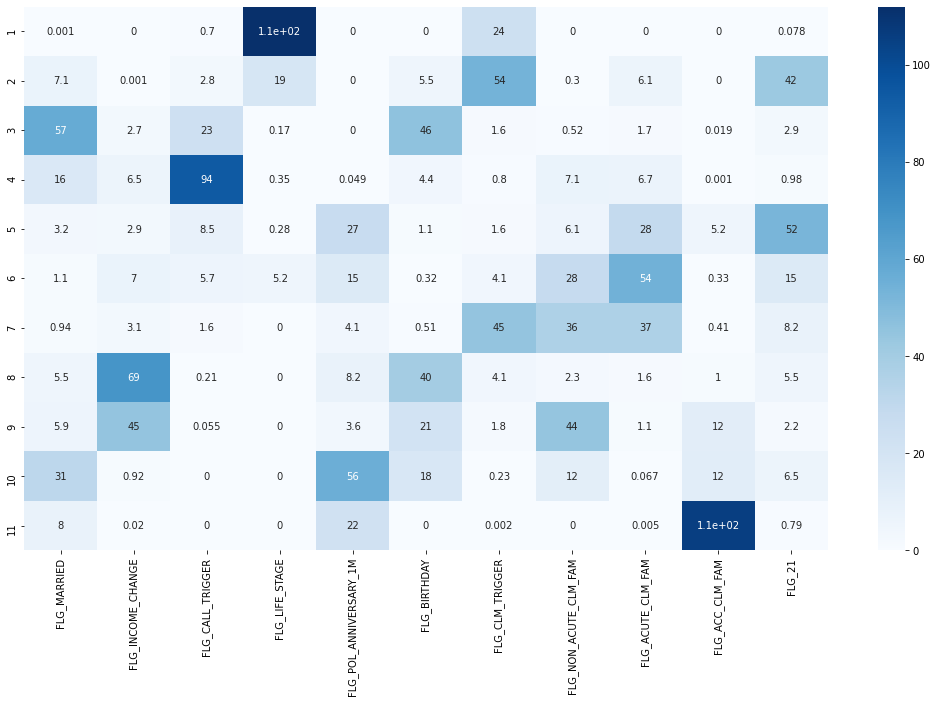

In [115]:
df6 = df6.fillna(0)
df6 = df6/1000
plt.figure(figsize = (18,10))

#create heatmap
sns.heatmap(df6,annot=True,cmap="Blues")

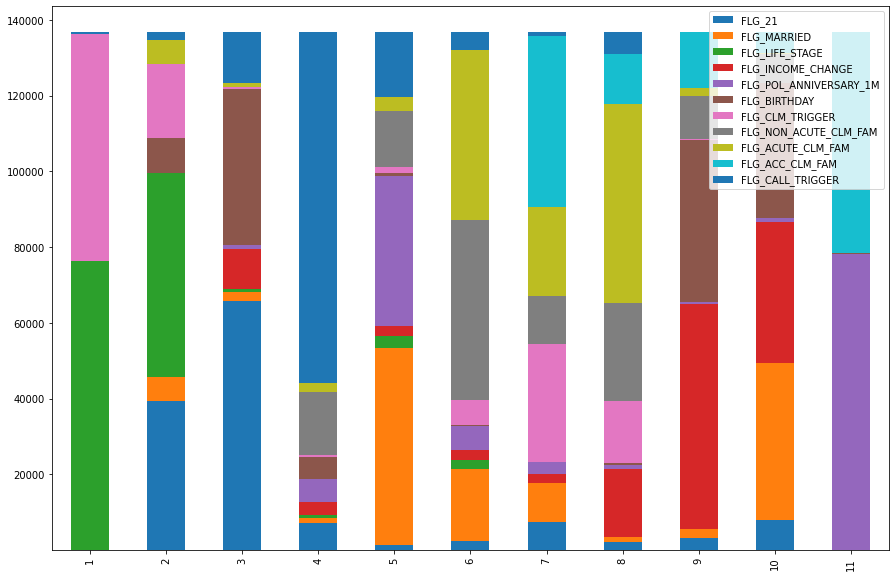

In [95]:
df6.plot(kind='bar',figsize=(15,10),stacked=True)
plt.legend(loc='upper right')
plt.show()

In [89]:
customer_features.head(11)

INS_ID  INS_RECENCY  INS_AGE  INS_BILL_AMT  INS_PP_POL  INS_KID_CT  \
0    282051           23      5.0       6000.00           1           0   
1    299865           20     15.0       1521.50           1           0   
2    111312           79     54.0          0.00           3           1   
3    804673           77     37.0     126801.86           3           0   
4    571688           24     22.0          0.00           1           0   
5    462296           45     14.0       2000.00           1           0   
6   1000722           60     45.0      18069.15           8           4   
7   1529065           10     20.0          0.00           1           0   
8    127131           24     35.0          0.00           0           2   
9    663921            1     51.0          0.00           2           1   
10   981585           48      7.0       8249.55           1           0   

    INS_INT_MYAIA_TRAN_3M  INS_NON_ACUTE  INS_PAID_AMT_ACUTE_6  \
0                       0              2                   0.0   
1                       0              0                1521.5   
2                       0              0                   0.0   
3                       0             11                   0.0   
4                       0              0                   0.0   
5                       0              2                3728.0   
6                       0              2                   0.0   
7                       0              0                   0.0   
8                       0              0                   0.0   
9                       1              0                   0.0   
10                      0              1                   0.0   

    INS_SMOKER_IND  ...  INS_LIFE_STAGE_Golden Ager  \
0                0  ...                           0   
1                0  ...                           0   
2                1  ...                           0   
3                1  ...                           0   
4                0  ...                           0   
5                0  ...                           0   
6                1  ...                           0   
7                0  ...                           0   
8                1  ...                           0   
9                0  ...                           0   
10               0  ...                           0   

    INS_INCOME_SEGM_G9 Mass Affluent  INS_CS_BAD_RISK  INS_BAD_RISK  \
0                                  0                0             0   
1                                  0                0             0   
2                                  0                0             0   
3                                  0                0             0   
4                                  0                0             0   
5                                  0                0             0   
6                                  1                0             2   
7                                  0                0             0   
8                                  0                0             0   
9                                  0                0             0   
10                                 0                0             0   

    INS_INT_EMAIL_3M  INS_INCOME_SEGM_G4 Mass  \
0                  0                        0   
1                  0                        0   
2                  0                        0   
3                  0                        0   
4                  0                        0   
5                  0                        0   
6                  0                        0   
7                  0                        0   
8                  0                        0   
9                  0                        0   
10                 0                        0   

    INS_INCOME_SEGM_G8 Mass Affluent  INS_INCOME_SEGM_G12 Mass Affluent  \
0                                  0                                  0   
1                                  0                      

In [235]:
df7 = df_train[['INS_ID','FLG_SUM','REPURCHASE_ANP','TARGET_REPUR_IND']]
#customer_features.set_index('INS_ID',inplace=True)
interactions.index = df_train.INS_ID

In [236]:
interaction1 = df7.merge(interactions, on='INS_ID', how='left')
df9 = customer_features.merge(interaction1, on='INS_ID', how='left')
df10 = df9.merge(df5, on='INS_ID', how='left')
df10.head()

INS_ID  INS_RECENCY  INS_AGE  INS_BILL_AMT  INS_PP_POL  INS_KID_CT  \
0  282051           23      5.0       6000.00           1           0   
1  299865           20     15.0       1521.50           1           0   
2  111312           79     54.0          0.00           3           1   
3  804673           77     37.0     126801.86           3           0   
4  571688           24     22.0          0.00           1           0   

   INS_INT_MYAIA_TRAN_3M  INS_PAID_AMT_ACUTE_6  INS_NON_ACUTE  INS_ACUTE_CT_6  \
0                      0                   0.0              2               0   
1                      0                1521.5              0               2   
2                      0                   0.0              0               0   
3                      0                   0.0             11               0   
4                      0                   0.0              0               0   

   ...  FLG_MARRIED  FLG_LIFE_STAGE  FLG_INCOME_CHANGE  \
0  ...            4               2                  8   
1  ...            4               3                  8   
2  ...           10               1                  8   
3  ...            4               2                  8   
4  ...           10               1                  8   

   FLG_POL_ANNIVERSARY_1M  FLG_BIRTHDAY  FLG_CLM_TRIGGER  \
0                      10             9                1   
1                       9            11                1   
2                       4             6                5   
3                      10             9                1   
4                       3             4                6   

   FLG_NON_ACUTE_CLM_FAM  FLG_ACUTE_CLM_FAM  FLG_ACC_CLM_FAM  FLG_CALL_TRIGGER  
0                      6                  7               11                 3  
1                      5                  7               10                 2  
2                      9                  7               11                 3  
3                      6                  7               11                 3  
4                      9                  7               11                 5  

[5 rows x 64 columns]

In [237]:
filepath = 'D:/Users/I008328/NRA/NRA_RecSys_Files/'
df10.to_csv(filepath +'full_result.csv',index=False)

In [238]:
ranking = df7.merge(df5, on='INS_ID', how='left')
weighted_score = df7.merge(interactions, on='INS_ID', how='left')
train_features = df7.merge(customer_features, on='INS_ID', how='left')

In [239]:
#filepath = 'D:/Users/I008328/NRA/NRA_RecSys_Files/'
ranking.to_csv(filepath +'rankings.csv')
weighted_score.to_csv(filepath +'weighted_score.csv')
train_features.to_csv(filepath +'train_features.csv',index=False)
#df10.to_csv(filepath +'full_result.csv',index=False)

In [ ]:
predicted_ranks1 = model.predict_rank(user_features=user_features1,
                                     item_features=item_features)

In [ ]:
ranks_df1 = pd.DataFrame(predicted_ranks1)
ranks_df1.columns = lst # item_category_scaled.index
ranks_df1.index = customer_features.index[cutoff:]
ranks_df1 = ranks_df1.T
ranks_df1 

In [ ]:
df3 = ranks_df1[581478].sort_values()
df3

In [ ]:
df4 = ranks_df1[9999].sort_values()
df4

In [ ]:
ndcg_at_k_test = ndcg_at_k(predicted_ranks, test_interactions, k=3) #80

In [ ]:
len(ndcg_at_k_test)

In [ ]:
ndcg_at_k_test

In [ ]:
df_train['DOB'] = pd.to_datetime(df_train['DOB'],errors = 'coerce')
df_train['ORIGINAL_INCEPTION_DT'] = pd.to_datetime(df_train['ORIGINAL_INCEPTION_DT'],errors = 'coerce')

In [ ]:
#['DOB','INS_MARITAL_STATUS_map','INS_MARITAL_STATUS_base','INS_LIFE_STAGE_map','INS_LIFE_STAGE_base']
df_train.dropna(subset=['DOB'], how='all', inplace=True)
df_train.shape


In [ ]:
df_train.dropna(subset=['INS_MARITAL_STATUS_map'], how='all', inplace=True)
df_train.shape

In [ ]:
df_train.dropna(subset=['INS_MARITAL_STATUS_base'], how='all', inplace=True)

In [ ]:
df_train.dropna(subset=['INS_LIFE_STAGE_map'], how='all', inplace=True)
df_train.shape

In [ ]:
df_train.dropna(subset=['INS_LIFE_STAGE_base'], how='all', inplace=True)
df_train.shape

In [ ]:
df_train['INS_INCOME_base'] = df_train['INS_INCOME_base'].fillna(0)
df_train['INS_INCOME_map'] = df_train['INS_INCOME_map'].fillna(0)

In [ ]:
df_train['FLG_NON_ACUTE_CLM_AMT_FAM'] = df_train['FLG_NON_ACUTE_CLM_AMT_FAM'].fillna(0)
df_train['FLG_ACUTE_CLM_AMT_FAM'] = df_train['FLG_ACUTE_CLM_AMT_FAM'].fillna(0)
df_train['FLG_ACC_CLM_AMT_FAM'] = df_train['FLG_ACC_CLM_AMT_FAM'].fillna(0)

In [ ]:
df_train.isnull().sum()

In [ ]:
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].apply(pd.Series.value_counts)

In [ ]:
targets = {'Y':1, 'N':0}
df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].stack().map(targets).unstack()

In [ ]:
df_train.columns

In [ ]:
df_train1 = df_train.copy()

In [ ]:
df_train2 = pd.get_dummies(data=df_train1,columns=['INS_MARITAL_STATUS_map', 'INS_MARITAL_STATUS_base',
       'INS_LIFE_STAGE_map', 'INS_LIFE_STAGE_base'])

In [ ]:
df_train2.columns

In [ ]:
df_train2[['FLG_21', 'FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE',
       'FLG_POL_ANNIVERSARY', 'FLG_BIRTHDAY', 'FLG_CLM_TRIGGER',
       'FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM', 'FLG_ACC_CLM_FAM',
       'FLG_CALL_TRIGGER']]

In [ ]:
df_train2.head()

In [ ]:
X = df_train2[['INS_INCOME_base', 'INS_INCOME_map', 
       'Anniversary_Month', 'Birth_Month', 'INS_NON_ACUTE_base',
       'INS_CLM_MAJOR_base', 'INS_ACUTE_CT_6_base',
       'INS_PAID_AMT_ACUTE_6_base', 'FLG_NON_ACUTE_CLM_AMT_FAM',
       'FLG_ACUTE_CLM_AMT_FAM', 'FLG_ACC_CLM_AMT_FAM', 'INS_INT_CALL_3M_base',
        'INS_MARITAL_STATUS_map_Divorced',
       'INS_MARITAL_STATUS_map_Married', 'INS_MARITAL_STATUS_map_Others',
       'INS_MARITAL_STATUS_map_Single', 'INS_MARITAL_STATUS_map_Widowed',
       'INS_MARITAL_STATUS_base_Divorced', 'INS_MARITAL_STATUS_base_Married',
       'INS_MARITAL_STATUS_base_Others', 'INS_MARITAL_STATUS_base_Single',
       'INS_MARITAL_STATUS_base_Widowed',
       'INS_LIFE_STAGE_map_Established Family',
       'INS_LIFE_STAGE_map_Golden Ager', 'INS_LIFE_STAGE_map_Mature Couple',
       'INS_LIFE_STAGE_map_Mature Single', 'INS_LIFE_STAGE_map_Minors ',
       'INS_LIFE_STAGE_map_Nest Builder', 'INS_LIFE_STAGE_map_Young Couple',
       'INS_LIFE_STAGE_map_Young Single',
       'INS_LIFE_STAGE_base_Established Family',
       'INS_LIFE_STAGE_base_Golden Ager', 'INS_LIFE_STAGE_base_Mature Couple',
       'INS_LIFE_STAGE_base_Mature Single', 'INS_LIFE_STAGE_base_Minors ',
       'INS_LIFE_STAGE_base_Nest Builder', 'INS_LIFE_STAGE_base_Young Couple',
       'INS_LIFE_STAGE_base_Young Single']]

y = df_train[['FLG_21','FLG_MARRIED', 'FLG_LIFE_STAGE', 'FLG_INCOME_CHANGE','FLG_POL_ANNIVERSARY','FLG_BIRTHDAY',
                                 'FLG_CLM_TRIGGER','FLG_NON_ACUTE_CLM_FAM', 'FLG_ACUTE_CLM_FAM','FLG_ACC_CLM_FAM',
                                 'FLG_CALL_TRIGGER']].stack().map(targets).unstack()

In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
#from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, train_size=0.80, random_state=0)
print(len(xtest))


In [ ]:
svc = SVC(gamma="scale")
model = MultiOutputClassifier(estimator=svc)

In [ ]:
rf = RandomForestClassifier()
model = MultiOutputClassifier(estimator=rf)

In [ ]:
model.fit(xtrain, ytrain)

In [ ]:
print(model.score(xtrain, ytrain))

In [ ]:
yhat = model.predict(xtest)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 45)

In [ ]:
# Test the model and print the classification report for each of the 36 categories.
def performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    for i, col in enumerate(y_test):
        print(col)
        print(classification_report(y_test[col], y_pred[:, i]))
        print(confusion_matrix(y_test[col], y_pred[:, i]))
        # print raw accuracy score 
        print('Accuracy Score: {}'.format(np.mean(y_test.values == y_pred)))

In [ ]:
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
performance(pipeline, X_test, y_test)

In [ ]:
# Use grid search to find better parameters. 
# Hyperparameter grid
parameters = {
              'clf__estimator__n_estimators': [50, 100], 
              'clf__estimator__min_samples_split': [2, 4]
             } 
# Create model
cv = GridSearchCV(pipeline, param_grid=parameters)

In [ ]:
# Train the tuned model.
cv.fit(X_train, y_train)

In [ ]:
# Test the tuned model and print the classification reports.
performance(cv, X_test, y_test)

In [ ]:
#preds = cv.predict_proba(X_test)
preds = cv.predict(X_test)

In [ ]:
preds

In [ ]:
preds[1]

In [ ]:
np.array(y_test.iloc[1:2,:]).T

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
cm_y1 = confusion_matrix(np.array(y_test.iloc[:1,:]).T,preds[0])
cm_y2 = confusion_matrix(np.array(y_test.iloc[1:2,:]).T,preds[1])

In [ ]:
cm_y1

In [ ]:
cm_y2

In [ ]:
print('Hamming loss: {0}'.format(hamming_loss(y_test, preds)))